<h1>Data Project - Spotify Charts</h1>

<h2>Introduction</h2>

Spotify is one of the leading music streaming platforms in the world today. Founded in 2006, they initially used pirated tracks to demonstrate their proof of concept, but has since worked with record companies, big and small, and even with independent artists to rack up billions of streams across the world daily, thanks to their massive user base and proprietary algorithms.

<h2>Building the database</h2>

Using Python as our primary tool, we will build a database of Daily Top 200 Tracks, with a selection of regions and a specifiable date range. This can be accomplished through web scraping using Selenium Webdriver to simulate logins and opening of the chart page for each date, reading the HTML elements of that page, inserting into a SQLite database, then moving onto the chart page for the next date.

In [1]:
import pandas as pd

In [2]:
# regions in South East Asia with Spotify availability
# the regions can be split across multiple scraping notebooks and run simulatenously to save time,
# but keep in mind request limits
region_dict = {
    "id" : "Indonesia",
    "my" : "Malaysia",
    "ph" : "Philippines",
    "sg" : "Singapore",
    "th" : "Thailand",
    "vn" : "Vietnam",
}

In [3]:
import datetime
now = pd.to_datetime(datetime.datetime.now()).strftime("%Y-%m-%d")
now

'2023-09-09'

In [4]:
start_date = '2017-01-01'
end_date = now
dates_list = pd.date_range(start=start_date, end=end_date).sort_values(ascending=True)

In [5]:
# this uses the firefox engine Geckodriver and sqlite as the database, make sure to have it installed
from selenium import webdriver
from selenium.webdriver.common.proxy import Proxy, ProxyType
from selenium.webdriver.firefox.service import Service
from webdriver_manager.firefox import GeckoDriverManager
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
import time
import sqlite3

In [6]:
conn = sqlite3.connect('data/charts-sea.db')
cursor = conn.cursor()

In [7]:
options = webdriver.FirefoxOptions()

driver = webdriver.Firefox(service=Service(GeckoDriverManager().install()), options=options)
print("Driver start")

driver.get("https://accounts.spotify.com/en/login?continue=https%3A%2F%2Fcharts.spotify.com/login")

username_field = driver.find_element(by="id", value="login-username")  # Replace with the actual username field ID
password_field = driver.find_element(by="id", value="login-password")  # Replace with the actual password field ID
login_button = driver.find_element(by="id", value="login-button")  # Replace with the actual login button ID

# Enter login credentials
username_field.send_keys("jerefe03@gmail.com")
password_field.send_keys("password123")

# Click the login button
login_button.click()

# Now you can perform your automation tasks after logging in

wait = WebDriverWait(driver, 10)
try:
    wait.until(EC.url_to_be('https://charts.spotify.com/charts/overview/global'))
    print("login success, redirecting")
    print("***")
    
    # main scraping logic
    for key in region_dict.keys():
        sub_chart = pd.DataFrame()
        
        cursor.execute(f"SELECT name FROM sqlite_master WHERE type='table' AND name='{key}'")
        result = cursor.fetchone()
        print(result)

        if result is not None:
            region_table = pd.read_sql_query("SELECT * FROM " + key, conn)
            continue_date = pd.to_datetime(region_table["date"].max()) + pd.DateOffset(days=1)
            print("table " + key + " found")
            if (continue_date > pd.to_datetime(end_date)):
                print("oh nose")
                break
            else:
                start_date = continue_date
                dates_list = pd.date_range(start=start_date, end=end_date).sort_values(ascending=True)
                print("continuing on " + start_date.strftime("%Y-%m-%d"))
        else:
            print("table " + key + " not found, creating table")
            start_date = '2017-01-01'
            dates_list = pd.date_range(start=start_date, end=end_date).sort_values(ascending=True)
            cursor.execute(f'''
                CREATE TABLE IF NOT EXISTS {key} (
                    id INTEGER PRIMARY KEY AUTOINCREMENT,
                    title TEXT,
                    rank INTEGER,
                    date TEXT,
                    artist TEXT,
                    url TEXT,
                    region TEXT,
                    streams INTEGER
                )
            ''')

        for date in dates_list:
            date_string = date.strftime("%Y-%m-%d")
            driver.get("https://charts.spotify.com/charts/view/regional-" + key + "-daily/" + date_string)
            try:
                WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.TAG_NAME, "tr")))
                print("Page load https://charts.spotify.com/charts/view/regional-" + key + "-daily/" + date_string + " success!")
                print("Scraping " + key + " " + date.strftime("%Y-%m-%d"))

                titles = driver.find_elements(By.CLASS_NAME, "kKOJRc")
                ranks = driver.find_elements(By.CLASS_NAME, "hgLxdb")
                artists = driver.find_elements(By.CLASS_NAME, "lfGOlT")
                artists = list(filter(lambda artists:\
                            len(artists.find_elements(By.CLASS_NAME, "bVVLJU")) > 0, artists))
                urls = driver.find_elements(By.CLASS_NAME, "gPJpnT")
                streams = driver.find_elements(By.CLASS_NAME, "cltvtH")

                for title, rank, artist_list, url, streams_count in zip (titles, ranks, artists, urls, streams):
                    title_string = title.text

                    rank_string = rank.text

                    artist_list_text_string = ""
                    artist_list_text = []
                    for artist in artist_list.find_elements(By.CLASS_NAME, "bVVLJU"):
                        artist_list_text.append(artist.text)
                    artist_list_text_string = ', '.join(map(str, artist_list_text))

                    anchor = url.find_element(By.TAG_NAME, "a")
                    anchor_string = anchor.get_attribute('href')

                    streams_count_string = streams_count.find_element(By.XPATH, './preceding-sibling::*[1]').text

                    cursor.execute(f'''INSERT INTO {key} (title, rank, date, artist, url, region, streams) VALUES (?, ?, ?, ?, ?, ?, ?)''',\
                                   (title_string, rank_string, date_string, artist_list_text_string, anchor_string, region_dict[key], streams_count_string))
                    # commit row to db
                    conn.commit()

                time.sleep(1)
            except:
                print("Page load https://charts.spotify.com/charts/view/regional-" + key + "-daily/" + date_string + " failed")
                print("Moving to next page..")
        
        print("sleeping for 10 seconds")
        print("***")
        time.sleep(10)
        
    print("Last date reached, ending driver")
    driver.quit()
        
except Exception as e:
    # Handle the exception and print it
    print(f"An exception occurred: {e}")
    conn.close()
    driver.quit()

C:\Users\moshpit_yoshi\AppData\Local\Temp\ipykernel_1012\284980263.py:3: DeprecationWarning: Firefox will soon stop logging to geckodriver.log by default; Specify desired logs with log_output
  driver = webdriver.Firefox(service=Service(GeckoDriverManager().install()), options=options)


Driver start
login success, redirecting
***
('id',)
table id found
continuing on 2023-08-29
Page load https://charts.spotify.com/charts/view/regional-id-daily/2023-08-29 success!
Scraping id 2023-08-29
Page load https://charts.spotify.com/charts/view/regional-id-daily/2023-08-30 success!
Scraping id 2023-08-30
Page load https://charts.spotify.com/charts/view/regional-id-daily/2023-08-31 success!
Scraping id 2023-08-31
Page load https://charts.spotify.com/charts/view/regional-id-daily/2023-09-01 success!
Scraping id 2023-09-01
Page load https://charts.spotify.com/charts/view/regional-id-daily/2023-09-02 success!
Scraping id 2023-09-02
Page load https://charts.spotify.com/charts/view/regional-id-daily/2023-09-03 success!
Scraping id 2023-09-03
Page load https://charts.spotify.com/charts/view/regional-id-daily/2023-09-04 success!
Scraping id 2023-09-04
Page load https://charts.spotify.com/charts/view/regional-id-daily/2023-09-05 success!
Scraping id 2023-09-05
Page load https://charts.spo

Page load https://charts.spotify.com/charts/view/regional-vn-daily/2023-09-09 failed
Moving to next page..
sleeping for 10 seconds
***
Last date reached, ending driver


In [8]:
# get all table names corresponding to each region
region_tables = pd.read_sql_query("SELECT * FROM sqlite_master where type='table' AND name NOT LIKE 'sqlite_%' AND name NOT LIKE '%track_data';", conn)["name"]

In [9]:
# scraped region tables
region_tables

0    id
1    my
2    ph
3    sg
4    th
5    vn
Name: name, dtype: object

In [10]:
# combine chart tables into one dataframe
charts_df = pd.DataFrame()

In [11]:
for region in region_tables:
    charts_df = charts_df.append(pd.read_sql_query("SELECT * FROM " + region, conn))

C:\Users\moshpit_yoshi\AppData\Local\Temp\ipykernel_1012\1600905904.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  charts_df = charts_df.append(pd.read_sql_query("SELECT * FROM " + region, conn))
C:\Users\moshpit_yoshi\AppData\Local\Temp\ipykernel_1012\1600905904.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  charts_df = charts_df.append(pd.read_sql_query("SELECT * FROM " + region, conn))
C:\Users\moshpit_yoshi\AppData\Local\Temp\ipykernel_1012\1600905904.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  charts_df = charts_df.append(pd.read_sql_query("SELECT * FROM " + region, conn))
C:\Users\moshpit_yoshi\AppData\Local\Temp\ipykernel_1012\1600905904.py:2: FutureWarning: The frame.append method is deprecated and

In [12]:
# check number of scraped rows per region
charts_df["region"].value_counts()

Philippines    487987
Singapore      487980
Malaysia       487782
Indonesia      486699
Thailand       438057
Vietnam        372776
Name: region, dtype: int64

In [13]:
# extract track_id from url and drop url column
charts_df["track_id"] = charts_df["url"].str.replace("https://open.spotify.com/track/", "")

C:\Users\moshpit_yoshi\AppData\Local\Temp\ipykernel_1012\3844909009.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  charts_df["track_id"] = charts_df["url"].str.replace("https://open.spotify.com/track/", "")


In [14]:
charts_df.drop("url", axis=1, inplace=True)

<h2>Check completeness in terms of date</h2>

looking deeper into the dataset using time series

In [15]:
# convert "date" column from string into pandas datetime then set as index
charts_df["date"] = pd.to_datetime(charts_df["date"])
charts_df.set_index("date", inplace=True)

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import MonthLocator, DateFormatter

In [26]:
def plot_region_chart_row_count_across_time(chart):
    plt.figure(figsize=(12, 3))
    sns.lineplot(data=chart.resample("M").size())
    plt.xticks(rotation=75, fontsize=7.5)
    plt.ylabel("row count")
    plt.title("Count of rows scraped")
    months = MonthLocator()
    months_fmt = DateFormatter('%b %Y')
    plt.gca().xaxis.set_major_locator(months)
    plt.gca().xaxis.set_major_formatter(months_fmt)
    plt.show()

In [40]:
def plot_region_chart_row_count_distribution(chart):
    per_date_count = chart["track_id"].groupby(["date"]).count()
    sns.histplot(per_date_count, kde=True)
    plt.title("Distribution of number of rows scraped")
    plt.ylabel("count of days")
    plt.xlabel("rows in day")
    plt.show()

In [41]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

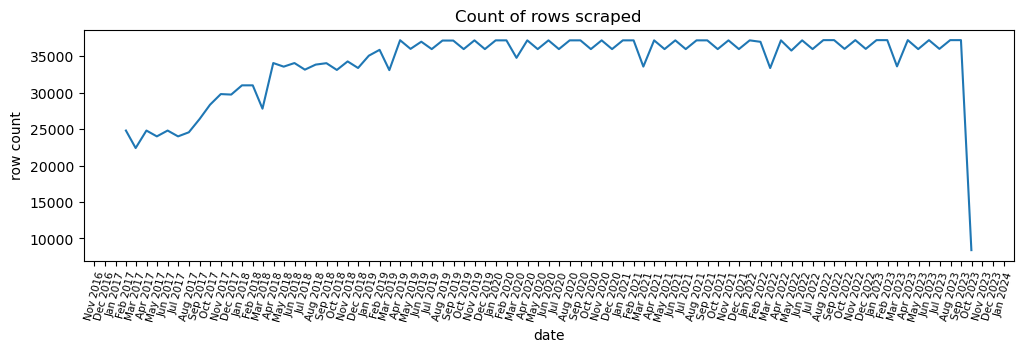

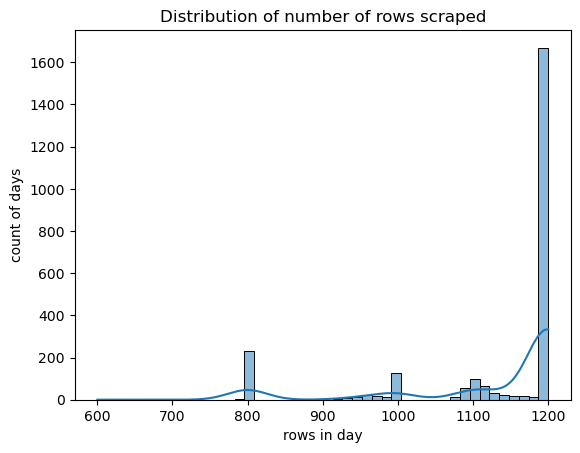

In [42]:
plot_region_chart_row_count_across_time(charts_df)
plot_region_chart_row_count_distribution(charts_df)

In [43]:
# check for missing days
date_range = pd.date_range(start=charts_df.index.min(), end=charts_df.index.max())

In [44]:
date_range

DatetimeIndex(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04',
               '2017-01-05', '2017-01-06', '2017-01-07', '2017-01-08',
               '2017-01-09', '2017-01-10',
               ...
               '2023-08-29', '2023-08-30', '2023-08-31', '2023-09-01',
               '2023-09-02', '2023-09-03', '2023-09-04', '2023-09-05',
               '2023-09-06', '2023-09-07'],
              dtype='datetime64[ns]', length=2441, freq='D')

In [45]:
for region in charts_df["region"].unique():
    print("Missing days: " + region)
    print(date_range[~date_range.isin(charts_df[charts_df["region"]==region].index)])
    print("***")

Missing days: Indonesia
DatetimeIndex(['2018-02-22', '2019-05-26'], dtype='datetime64[ns]', freq=None)
***
Missing days: Malaysia
DatetimeIndex(['2017-07-24', '2022-02-13'], dtype='datetime64[ns]', freq=None)
***
Missing days: Philippines
DatetimeIndex(['2022-04-03'], dtype='datetime64[ns]', freq='D')
***
Missing days: Singapore
DatetimeIndex(['2022-01-22'], dtype='datetime64[ns]', freq='D')
***
Missing days: Thailand
DatetimeIndex(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04',
               '2017-01-05', '2017-01-06', '2017-01-07', '2017-01-08',
               '2017-01-09', '2017-01-10',
               ...
               '2017-08-13', '2017-08-14', '2017-08-15', '2017-08-16',
               '2017-08-17', '2017-08-18', '2017-08-19', '2017-08-20',
               '2017-08-21', '2017-08-22'],
              dtype='datetime64[ns]', length=234, freq='D')
***
Missing days: Vietnam
DatetimeIndex(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04',
               '2017-01-05', '2

In [47]:
charts_df["streams"] = charts_df["streams"].str.replace(",","").astype(int)

In [48]:
# summary statistics
for region in charts_df["region"].unique():
    print("Summary statistics for streams: " + region)
    print(charts_df[charts_df["region"]==region]["streams"].describe())
    print("***")

Summary statistics for streams: Indonesia
count    486699.000
mean      71447.119
std       87250.526
min        3113.000
25%       24926.000
50%       42575.000
75%       84677.000
max     1780047.000
Name: streams, dtype: float64
***
Summary statistics for streams: Malaysia
count   487782.000
mean     13225.461
std      10945.215
min       2136.000
25%       6846.000
50%       9700.000
75%      15474.000
max     357578.000
Name: streams, dtype: float64
***
Summary statistics for streams: Philippines
count    487987.000
mean      64284.533
std       56114.633
min       11004.000
25%       29475.000
50%       43571.000
75%       79407.000
max     1280781.000
Name: streams, dtype: float64
***
Summary statistics for streams: Singapore
count   487980.000
mean     11248.523
std       8142.966
min       2224.000
25%       6698.000
50%       8437.000
75%      12693.000
max     183257.000
Name: streams, dtype: float64
***
Summary statistics for streams: Thailand
count    438057.000
mean      

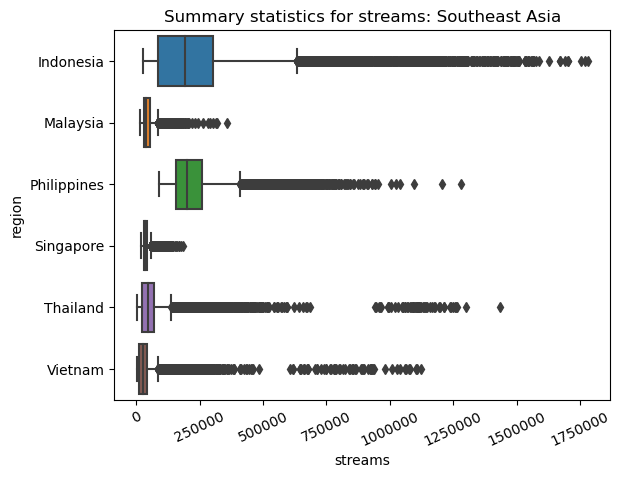

In [63]:
sns.boxplot(x="streams", y="region", data=charts_df[charts_df["rank"]<10])
plt.ticklabel_format(style='plain', axis='x', useOffset=False)
plt.xticks(rotation=25)
plt.title("Summary statistics for streams: Southeast Asia")
plt.show()

note that there are many outliers

<h2>Get Track Data using Spotify Web Api and SpotiPy</h2>

We can get track information from Spotify Web Api and combine it with our previously extracted chart data. To do this, we identify the unique tracks in our chart data, get the track_ids of the unique tracks and and loop the track data getter over this list.

In [50]:
import time
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

In [51]:
# track data getter function
def get_track_data(t_id, client_id_param, client_secret_param):
    client_credentials_manager = SpotifyClientCredentials(client_id=client_id_param,
                                                          client_secret=client_secret_param)
    sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)
    
    track_data = sp.track(t_id)
    track_features = sp.audio_features(t_id)
    
    #get only main(first) artist
    td_list = [t_id,\
               track_data['name'],\
               track_data['artists'][0]['id'],\
               track_data['artists'][0]['name'],\
               track_data['album']['uri'].split(":")[2],\
               track_data['duration_ms'],\
               track_data['album']['release_date'],\
               track_data['popularity']]
    data = pd.DataFrame([td_list], columns = ['track_id','track_name','artist_id','artist_name','album_id','duration','release_date','popularity'])

    relevant_cols = ['danceability', 'energy', 'key', 'loudness', 'mode',\
                     'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']  
    
    #if audio features are not available
    if track_features==[None]:
        tf_data = pd.DataFrame([{x:None for x in relevant_cols}])
    else:
        tf_data = pd.DataFrame(track_features)
        tf_data = tf_data[relevant_cols]
    
    data = pd.concat([data, tf_data], axis=1)
    return data

In [52]:
downloaded_track_ids = []

def get_tracks_slice_data(tracks_slice, client_id_param, client_secret_param):

    track_df = tracks_slice
    track_list = track_df['track_id'].values
    
    for i,track_id in enumerate(track_list):    
        if track_id in downloaded_track_ids:
            continue
        else:
            print('[%d/%d] Fetching track data for %s... ' % 
                  (i+1,len(track_list),track_df[track_df['track_id']==track_id]['title'].values[0]), end = " ") 

            try:
                track_data = get_track_data(track_id, client_id_param, client_secret_param) 
                downloaded_track_ids.append(track_id)
                cursor.execute(f'''INSERT INTO track_data (track_id, track_name, artist_id, artist_name, album_id, duration, release_date, popularity, danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)''',\
                                   (track_data["track_id"][0],
                                    track_data["track_name"][0],
                                    track_data["artist_id"][0],
                                    track_data["artist_name"][0],
                                    track_data["album_id"][0],
                                    int(track_data["duration"][0]),
                                    track_data["release_date"][0],
                                    int(track_data["popularity"][0]),
                                    float(track_data["danceability"][0]),
                                    float(track_data["energy"][0]),
                                    int(track_data["key"][0]),
                                    float(track_data["loudness"][0]),
                                    int(track_data["mode"][0]),
                                    float(track_data["speechiness"][0]),
                                    float(track_data["acousticness"][0]),
                                    float(track_data["instrumentalness"][0]),
                                    float(track_data["liveness"][0]),
                                    float(track_data["valence"][0]),
                                    float(track_data["tempo"][0])))
                conn.commit()
                print("done!")
            except Exception as e:
                print(e)

            # sleep for 100 secs per 100 requests to avoid being blocked
            if (i % 100 == 0)&(i > 0):
                time.sleep(10)

In [53]:
# tracks_slice: so we can distribute retrieval of track data across client_ids and client_secrets for bigger datasets
# downloaded_track_ids: so we can continue on last track data retrieved in case of disconnection

In [54]:
# get unique tracks in charts
charts_unique_tracks = charts_df.groupby(["title", "artist", "track_id"]).size().reset_index(name="count")

In [55]:
charts_unique_tracks.sort_values(by="count", ascending=False)

,title,artist,track_id,count
9675,Say You Won't Let Go,James Arthur,5uCax9HTNlzGybIStD3vDh,10622
8607,Perfect,Ed Sheeran,0tgVpDi06FyKpA1z0VMD4v,9923
8665,Photograph,Ed Sheeran,6fxVffaTuwjgEk5h9QyRjy,9741
123,2002,Anne-Marie,2BgEsaKNfHUdlh97KmvFyo,8728
4988,I Like Me Better,Lauv,2P91MQbaiQOfbiz9VqhqKQ,8478
...,...,...,...,...
13347,trời giấu trời mang đi,AMEE,5bci9SuYMCNB2BkSEmrCaB,1
10234,Somebody Told Me,Charlie Puth,1PuQTv1Kr1gzLgVeATSuh6,1
13354,tỉnh thức sau giấc ngủ đông,GREY D,4Xai78OB5OKQI9EFYcCzxD,1
10230,Somebody To Love,Troye Sivan,5hYShQIail8SGWfbpTOo8K,1


In [56]:
charts_unique_tracks

,title,artist,track_id,count
0,# umakeme (feat. KNY & Ox The Moron),"Xuân Nghi, kny, Ox The Moron",5MJgMHroAGmTvMN2Q1aCNH,5
1,#AiChoAi,"Flo D, Giang Nguyễn",5xOkL4eAs735nm6mcnvfS6,180
2,#Glaiter,"VKL, Roony",1L9obzxoUqbYVxTqbGBS6O,7
3,#IDONTNEEDNOPETERPANTOSHOWMEWHATTODO,Quarterjack,64kbi0kNr7D5IzwpOVPXe4,2
4,#คนเหงา2018,"Point, Art Marut",663hJaCpsyLwUGqj7TEXRZ,23
...,...,...,...,...
15652,어질어질 (Outta My Head),JEON SOMI,4dwwfiOzRNlKNUSgfx4Z2k,15
15653,운명 The Chance of Love,TVXQ!,3XzxHvEomjJIKZcZqYfFut,1
15654,키스는 다음에,LOONA,3DGKXLtVjawKFweymvHn84,3
15655,하루살이,"DEAN, SULLI, Rad Museum",2AA1f7utyvXpmtKsEvp5lz,3


In [57]:
# divide tracks to avoid timeouts from API
tracks_slice_1 = charts_unique_tracks[0:8000]
tracks_slice_2 = charts_unique_tracks[8000:]

In [58]:
tracks_slices = [
    tracks_slice_1,
    tracks_slice_2
]

client_ids = [
    "fe07a9a23ea54344be9aa80e33d7583b",
    "9971fa3231494ce9aa0bf8fc22622044"
]

client_secrets = [
    "710d45475521432db507f82d4f99fd54",
    "a4c187a9c6ac4b4fb01ea30cc51cfdd6"
]

In [59]:
conn = sqlite3.connect('data/charts-sea.db')
cursor = conn.cursor()

cursor.execute(f'''
    CREATE TABLE IF NOT EXISTS track_data (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        track_id TEXT,
        track_name TEXT,
        artist_id TEXT,
        artist_name TEXT,
        album_id TEXT,
        duration INTEGER,
        release_date TEXT,
        popularity INTEGER,
        danceability FLOAT,
        energy FLOAT,
        key INTEGER,
        loudness FLOAT,
        mode INTEGER,
        speechiness FLOAT,
        acousticness FLOAT,
        instrumentalness FLOAT,
        liveness FLOAT,
        valence FLOAT,
        tempo FLOAT
    )
''')

In [60]:
for iteration in range(0,2):
    print("***")
    print("Iteration " + str(iteration))
    get_tracks_slice_data(tracks_slices[iteration], client_ids[iteration], client_secrets[iteration])

***
Iteration 0
[1/8000] Fetching track data for # umakeme (feat. KNY & Ox The Moron)...  done!
[2/8000] Fetching track data for #AiChoAi...  done!
[3/8000] Fetching track data for #Glaiter...  done!
[4/8000] Fetching track data for #IDONTNEEDNOPETERPANTOSHOWMEWHATTODO...  done!
[5/8000] Fetching track data for #คนเหงา2018...  done!
[6/8000] Fetching track data for %%(Eung Eung)...  done!
[7/8000] Fetching track data for 'Til We Meet Again...  done!
[8/8000] Fetching track data for 'Tâm tình' medley...  done!
[9/8000] Fetching track data for 'bout you...  done!
[10/8000] Fetching track data for 'yêu yêu yêu' mashup...  done!
[11/8000] Fetching track data for (Everything I Do) I Do It For You...  done!
[12/8000] Fetching track data for (Everything I Do) I Do It For You...  done!
[13/8000] Fetching track data for (Fuck A) Silver Lining...  done!
[14/8000] Fetching track data for (It Goes Like) Nanana - Edit...  done!
[15/8000] Fetching track data for (Not) The One...  done!
[16/8000] Fet

[136/8000] Fetching track data for 21st Century Girl...  done!
[137/8000] Fetching track data for 21st Century Girl...  done!
[138/8000] Fetching track data for 21st Century Girl...  done!
[139/8000] Fetching track data for 22...  done!
[140/8000] Fetching track data for 22...  done!
[141/8000] Fetching track data for 22 (Taylor's Version)...  done!
[142/8000] Fetching track data for 22 (Taylor's Version)...  done!
[143/8000] Fetching track data for 24...  done!
[144/8000] Fetching track data for 24 to 25...  done!
[145/8000] Fetching track data for 24/7...  done!
[146/8000] Fetching track data for 24/7...  done!
[147/8000] Fetching track data for 24/7, 365...  done!
[148/8000] Fetching track data for 241...  done!
[149/8000] Fetching track data for 241 - From "100 Tula Para Kay Stella"...  done!
[150/8000] Fetching track data for 247...  done!
[151/8000] Fetching track data for 24H...  done!
[152/8000] Fetching track data for 24K Magic...  done!
[153/8000] Fetching track data for 24h.

[271/8000] Fetching track data for A Holly Jolly Christmas...  done!
[272/8000] Fetching track data for A Keeper...  done!
[273/8000] Fetching track data for A L I E N S...  done!
[274/8000] Fetching track data for A LIGHT THAT NEVER COMES...  done!
[275/8000] Fetching track data for A Lamenting Song...  done!
[276/8000] Fetching track data for A Line in the Sand...  done!
[277/8000] Fetching track data for A Little More...  done!
[278/8000] Fetching track data for A Love to Last a Lifetime...  done!
[279/8000] Fetching track data for A Lovely Night...  done!
[280/8000] Fetching track data for A Magnificent Uncoiling...  done!
[281/8000] Fetching track data for A Man Without Love...  done!
[282/8000] Fetching track data for A Message...  done!
[283/8000] Fetching track data for A Million Dreams...  done!
[284/8000] Fetching track data for A Million Dreams...  done!
[285/8000] Fetching track data for A Million Dreams...  done!
[286/8000] Fetching track data for A Million Dreams (Reprise

[403/8000] Fetching track data for After Party...  done!
[404/8000] Fetching track data for After School...  done!
[405/8000] Fetching track data for Afterglow...  done!
[406/8000] Fetching track data for Afterglow...  done!
[407/8000] Fetching track data for Afterthought...  done!
[408/8000] Fetching track data for Ag1...  done!
[409/8000] Fetching track data for Agachaito...  done!
[410/8000] Fetching track data for Again...  done!
[411/8000] Fetching track data for Again...  done!
[412/8000] Fetching track data for Again (feat. XXXTENTACION)...  done!
[413/8000] Fetching track data for Agent Orange...  done!
[414/8000] Fetching track data for Agust D...  done!
[415/8000] Fetching track data for Ah Yeah...  done!
[416/8000] Fetching track data for Ah puh...  done!
[417/8000] Fetching track data for Ai Chung Tình Bằng Cô Đơn...  done!
[418/8000] Fetching track data for Ai Cũng Có Thể Là Quán Quân (feat. Dick & Bùi Công Nam)...  done!
[419/8000] Fetching track data for Ai Là Người Thươ

[534/8000] Fetching track data for All Good - Acoustic Version...  done!
[535/8000] Fetching track data for All I Am...  done!
[536/8000] Fetching track data for All I Ask...  done!
[537/8000] Fetching track data for All I Ask...  done!
[538/8000] Fetching track data for All I Can Think About Is You...  done!
[539/8000] Fetching track data for All I Got...  done!
[540/8000] Fetching track data for All I Know So Far...  done!
[541/8000] Fetching track data for All I Need To Hear...  done!
[542/8000] Fetching track data for All I Wanna Do...  done!
[543/8000] Fetching track data for All I Wanna Do (K) (Feat. Hoody & Loco)...  done!
[544/8000] Fetching track data for All I Want...  done!
[545/8000] Fetching track data for All I Want...  done!
[546/8000] Fetching track data for All I Want (For Christmas)...  done!
[547/8000] Fetching track data for All I Want (For Christmas)...  done!
[548/8000] Fetching track data for All I Want - From "High School Musical: The Musical: The Series"...  do

[657/8000] Fetching track data for Andaikan Kau Datang - From "Miracle in Cell No. 7"...  done!
[658/8000] Fetching track data for Andainya Takdir...  done!
[659/8000] Fetching track data for Andito Tayo Para Sa Isa’t Isa...  done!
[660/8000] Fetching track data for Andiyan...  done!
[661/8000] Fetching track data for Andromeda (feat. DRAM)...  done!
[662/8000] Fetching track data for Ang Huling El Bimbo...  done!
[663/8000] Fetching track data for Ang Huling El Bimbo...  done!
[664/8000] Fetching track data for Ang Pag-ibig...  done!
[665/8000] Fetching track data for Ang Pinagmulan...  done!
[666/8000] Fetching track data for Ang Presidente Bise Presidente...  done!
[667/8000] Fetching track data for Ang Wakas (feat. Trisha Macapagal)...  done!
[668/8000] Fetching track data for Ang Wakas (feat. Trisha Macapagal)...  done!
[669/8000] Fetching track data for Anganku Anganmu...  done!
[670/8000] Fetching track data for Anganku Anganmu (With Raisa) (with Raisa)...  done!
[671/8000] Fetc

[777/8000] Fetching track data for Apalah (Arti Menunggu)...  done!
[778/8000] Fetching track data for Apapun Yang Terjadi...  done!
[779/8000] Fetching track data for Apapun Yang Terjadi...  done!
[780/8000] Fetching track data for Ape Sia...  done!
[781/8000] Fetching track data for Apocalypse...  done!
[782/8000] Fetching track data for Apologize...  done!
[783/8000] Fetching track data for Apologize...  done!
[784/8000] Fetching track data for Apple...  done!
[785/8000] Fetching track data for April...  done!
[786/8000] Fetching track data for April...  done!
[787/8000] Fetching track data for April...  done!
[788/8000] Fetching track data for April...  done!
[789/8000] Fetching track data for April shower...  done!
[790/8000] Fetching track data for Aqilah...  done!
[791/8000] Fetching track data for Arabesque...  done!
[792/8000] Fetching track data for Arabian Nights (2019)...  done!
[793/8000] Fetching track data for Arabic Kuthu - Halamithi Habibo (From "Beast")...  done!
[794

[907/8000] Fetching track data for BAD!...  done!
[908/8000] Fetching track data for BAD!...  done!
[909/8000] Fetching track data for BADBOY...  done!
[910/8000] Fetching track data for BADBYE...  done!
[911/8000] Fetching track data for BALI...  done!
[912/8000] Fetching track data for BAMBOLEO...  done!
[913/8000] Fetching track data for BANG BANG BANG...  done!
[914/8000] Fetching track data for BBIBBI...  done!
[915/8000] Fetching track data for BBoom BBoom...  done!
[916/8000] Fetching track data for BBoom BBoom...  done!
[917/8000] Fetching track data for BDZ...  done!
[918/8000] Fetching track data for BE WITH ME...  done!
[919/8000] Fetching track data for BE WITH ME...  done!
[920/8000] Fetching track data for BEAUTIFUL...  done!
[921/8000] Fetching track data for BEAUTIFUL...  done!
[922/8000] Fetching track data for BEAUTIFUL - Ballad Ver....  done!
[923/8000] Fetching track data for BEAUTIFUL MONSTER...  done!
[924/8000] Fetching track data for BEHIND THE MASK...  done!
[9

[1038/8000] Fetching track data for Back to You (feat. Bebe Rexha & Digital Farm Animals)...  done!
[1039/8000] Fetching track data for BackOutsideBoyz...  done!
[1040/8000] Fetching track data for Backlight...  done!
[1041/8000] Fetching track data for Backroom...  done!
[1042/8000] Fetching track data for Backyard Boy...  done!
[1043/8000] Fetching track data for Backyard Boy...  done!
[1044/8000] Fetching track data for Backyard Boy (with Jeremy Zucker)...  done!
[1045/8000] Fetching track data for Bad...  done!
[1046/8000] Fetching track data for Bad...  done!
[1047/8000] Fetching track data for Bad Alive...  done!
[1048/8000] Fetching track data for Bad Alive - English Version...  done!
[1049/8000] Fetching track data for Bad At Love...  done!
[1050/8000] Fetching track data for Bad Bitch (feat. Ty Dolla $ign)...  done!
[1051/8000] Fetching track data for Bad Blood...  done!
[1052/8000] Fetching track data for Bad Boy...  done!
[1053/8000] Fetching track data for Bad Boy...  done!

[1165/8000] Fetching track data for Be My Ocean...  done!
[1166/8000] Fetching track data for Be Okay Again Today...  done!
[1167/8000] Fetching track data for Be Okay Again Today...  done!
[1168/8000] Fetching track data for Be Our Guest...  done!
[1169/8000] Fetching track data for Be Right Now...  done!
[1170/8000] Fetching track data for Be Somebody...  done!
[1171/8000] Fetching track data for Be Somebody...  done!
[1172/8000] Fetching track data for Be There For You...  done!
[1173/8000] Fetching track data for Be There For You...  done!
[1174/8000] Fetching track data for Be With You...  done!
[1175/8000] Fetching track data for Be the One...  done!
[1176/8000] Fetching track data for Beach House...  done!
[1177/8000] Fetching track data for Beach House...  done!
[1178/8000] Fetching track data for Beast Mode (From "Beast")...  done!
[1179/8000] Fetching track data for Beatbox...  done!
[1180/8000] Fetching track data for Beatbox - English Version...  done!
[1181/8000] Fetching 

[1289/8000] Fetching track data for Berakhir Sama...  done!
[1290/8000] Fetching track data for Berakhir Sama...  done!
[1291/8000] Fetching track data for Berakhirlah Sudah...  done!
[1292/8000] Fetching track data for Beranjak Dewasa...  done!
[1293/8000] Fetching track data for Berawal Dari Tatap...  done!
[1294/8000] Fetching track data for Berdua Bersama...  done!
[1295/8000] Fetching track data for Berdua Bersama...  done!
[1296/8000] Fetching track data for Berdua Saja...  done!
[1297/8000] Fetching track data for Bergema Takbir Di Pagi Raya...  done!
[1298/8000] Fetching track data for Berharap Tak Berpisah...  done!
[1299/8000] Fetching track data for Berhenti Berharap...  done!
[1300/8000] Fetching track data for Berisik...  done!
[1301/8000] Fetching track data for Berisik...  done!
[1302/8000] Fetching track data for Berita Kehilangan...  done!
[1303/8000] Fetching track data for Berkawan Dengan Rindu...  done!
[1304/8000] Fetching track data for Berlin...  done!
[1305/8000

[1417/8000] Fetching track data for Binalewala - Acoustic Version...  done!
[1418/8000] Fetching track data for Binalewala - Original Version...  done!
[1419/8000] Fetching track data for Bing Bing...  done!
[1420/8000] Fetching track data for BingBian 病变...  done!
[1421/8000] Fetching track data for Bingle Bangle...  done!
[1422/8000] Fetching track data for Binhi...  done!
[1423/8000] Fetching track data for Binhi...  done!
[1424/8000] Fetching track data for Binibini...  done!
[1425/8000] Fetching track data for Binibini...  done!
[1426/8000] Fetching track data for Binibini...  done!
[1427/8000] Fetching track data for Binibini (Last Day On Earth) (feat. James TW)...  done!
[1428/8000] Fetching track data for Bintang di Surga...  done!
[1429/8000] Fetching track data for Bintang di Surga...  done!
[1430/8000] Fetching track data for Birds...  done!
[1431/8000] Fetching track data for Birdy...  done!
[1432/8000] Fetching track data for Birthday...  done!
[1433/8000] Fetching track d

[1548/8000] Fetching track data for Bojo Galak...  done!
[1549/8000] Fetching track data for Bom...  done!
[1550/8000] Fetching track data for Bom Bidi Bom - From "Fifty Shades Darker (Original Motion Picture Soundtrack)"...  done!
[1551/8000] Fetching track data for Bomb Bomb...  done!
[1552/8000] Fetching track data for Bomba...  done!
[1553/8000] Fetching track data for Bombs...  done!
[1554/8000] Fetching track data for Bon Appétit...  done!
[1555/8000] Fetching track data for Bon Bon Chocolat...  done!
[1556/8000] Fetching track data for Bon Voyage...  done!
[1557/8000] Fetching track data for Boneka...  done!
[1558/8000] Fetching track data for Bones...  done!
[1559/8000] Fetching track data for Bones...  done!
[1560/8000] Fetching track data for Bones (feat. OneRepublic)...  done!
[1561/8000] Fetching track data for Boo'd Up...  done!
[1562/8000] Fetching track data for Boom...  done!
[1563/8000] Fetching track data for Boomerang...  done!
[1564/8000] Fetching track data for Boo

[1681/8000] Fetching track data for Bumi Dan Bulan...  done!
[1682/8000] Fetching track data for Bumi Dan Bulan...  done!
[1683/8000] Fetching track data for Bunga...  done!
[1684/8000] Fetching track data for Bunga...  done!
[1685/8000] Fetching track data for Bunga...  done!
[1686/8000] Fetching track data for Bunga...  done!
[1687/8000] Fetching track data for Bunga...  done!
[1688/8000] Fetching track data for Bunga Di Telinga...  done!
[1689/8000] Fetching track data for Bungee...  done!
[1690/8000] Fetching track data for Bungee...  done!
[1691/8000] Fetching track data for Burn...  done!
[1692/8000] Fetching track data for Burn...  done!
[1693/8000] Fetching track data for Burn It (feat. MAX)...  done!
[1694/8000] Fetching track data for Burn It Up...  done!
[1695/8000] Fetching track data for Burn It Up...  done!
[1696/8000] Fetching track data for Burn It Up...  done!
[1697/8000] Fetching track data for Burn It Up (Prequel Remix)...  done!
[1698/8000] Fetching track data for B

[1813/8000] Fetching track data for CHUYỂN KÊNH (sản phẩm này không phải là thuốc)...  done!
[1814/8000] Fetching track data for CHUÔNG BÁO THỨC (sáng rồi)...  done!
[1815/8000] Fetching track data for CHƠI...  done!
[1816/8000] Fetching track data for CHẠY NGAY ĐI...  done!
[1817/8000] Fetching track data for CHẠY NGAY ĐI - Onionn Remix...  done!
[1818/8000] Fetching track data for CIAO...  done!
[1819/8000] Fetching track data for CILU...  done!
[1820/8000] Fetching track data for CIRCUS MAXIMUS (feat. The Weeknd & Swae Lee)...  done!
[1821/8000] Fetching track data for CITY OF ANGELS...  done!
[1822/8000] Fetching track data for CIVIL WAR - Bonus...  done!
[1823/8000] Fetching track data for CLAP...  done!
[1824/8000] Fetching track data for CLAP!...  done!
[1825/8000] Fetching track data for CLAP!...  done!
[1826/8000] Fetching track data for CLME...  done!
[1827/8000] Fetching track data for COCKTAIL...  done!
[1828/8000] Fetching track data for COLORS...  done!
[1829/8000] Fetchi

[1941/8000] Fetching track data for Captain (Namjun Theme) (BTS World Original Soundtrack) (Instrumental)...  done!
[1942/8000] Fetching track data for Capture...  done!
[1943/8000] Fetching track data for Car Crash...  done!
[1944/8000] Fetching track data for Car's Outside...  done!
[1945/8000] Fetching track data for Car's Outside - Sped Up Version...  done!
[1946/8000] Fetching track data for Caramel Cream...  done!
[1947/8000] Fetching track data for Carino Brutal...  done!
[1948/8000] Fetching track data for Carol of the Bells...  done!
[1949/8000] Fetching track data for Carolina...  done!
[1950/8000] Fetching track data for Carolina - From The Motion Picture “Where The Crawdads Sing”...  done!
[1951/8000] Fetching track data for Caroline...  done!
[1952/8000] Fetching track data for Caroline...  done!
[1953/8000] Fetching track data for Caroline...  done!
[1954/8000] Fetching track data for Carpool...  done!
[1955/8000] Fetching track data for Carry Me Away...  done!
[1956/8000

[2069/8000] Fetching track data for Chim Sẻ Và Dâu Tây (feat. Dế Choắt & Wowy)...  done!
[2070/8000] Fetching track data for China...  done!
[2071/8000] Fetching track data for Chinese New Year...  done!
[2072/8000] Fetching track data for Chinita...  done!
[2073/8000] Fetching track data for Chinita Girl...  done!
[2074/8000] Fetching track data for Chinito...  done!
[2075/8000] Fetching track data for Cho Em Một Lần Yêu...  done!
[2076/8000] Fetching track data for Cho Em Một Lần Yêu...  done!
[2077/8000] Fetching track data for Cho Không...  done!
[2078/8000] Fetching track data for Cho Mình Em...  done!
[2079/8000] Fetching track data for Cho Ngày Không Còn Nhau...  done!
[2080/8000] Fetching track data for Cho Tôi Lang Thang...  done!
[2081/8000] Fetching track data for Cho Tôi Lang Thang...  done!
[2082/8000] Fetching track data for Cho Tôi Lang Thang...  done!
[2083/8000] Fetching track data for Chocolate...  done!
[2084/8000] Fetching track data for Chocolate...  done!
[2085/80

[2189/8000] Fetching track data for Chợt Nhìn Nhau...  done!
[2190/8000] Fetching track data for Chợt Thấy Em Khóc...  done!
[2191/8000] Fetching track data for Ciao Adios...  done!
[2192/8000] Fetching track data for Cidro...  done!
[2193/8000] Fetching track data for Cigarettes...  done!
[2194/8000] Fetching track data for Cigarettes & Cush (feat. Kehlani & Lily Allen)...  done!
[2195/8000] Fetching track data for Cincin...  done!
[2196/8000] Fetching track data for Cinderella...  done!
[2197/8000] Fetching track data for Cinderella...  done!
[2198/8000] Fetching track data for Cinderella - From "Hero Seorang Cinderella" Soundtrack...  done!
[2199/8000] Fetching track data for Cinema...  done!
[2200/8000] Fetching track data for Cinta...  done!
[2201/8000] Fetching track data for Cinta...  done!
[2202/8000] Fetching track data for Cinta (feat. Kris Dayanti)...  done!
[2203/8000] Fetching track data for Cinta Begini...  done!
[2204/8000] Fetching track data for Cinta Dalam Hati...  do

[2315/8000] Fetching track data for Coming Home (Sung by TAEIL, DOYOUNG, JAEHYUN, HAECHAN)...  done!
[2316/8000] Fetching track data for Complex (Feat. G-DRAGON)...  done!
[2317/8000] Fetching track data for Complicated...  done!
[2318/8000] Fetching track data for Complicated (feat. Kiiara)...  done!
[2319/8000] Fetching track data for Con Bướm Xuân...  done!
[2320/8000] Fetching track data for Con Calma...  done!
[2321/8000] Fetching track data for Con Gái Như Em...  done!
[2322/8000] Fetching track data for Con La Brisa...  done!
[2323/8000] Fetching track data for Con Nhà Người Ta (feat. Ricky Star)...  done!
[2324/8000] Fetching track data for Con roi cua em...  done!
[2325/8000] Fetching track data for Con Đường Mưa...  done!
[2326/8000] Fetching track data for Conceited...  done!
[2327/8000] Fetching track data for Confetti...  done!
[2328/8000] Fetching track data for Confetti...  done!
[2329/8000] Fetching track data for Confetti (feat. Saweetie)...  done!
[2330/8000] Fetching

[2443/8000] Fetching track data for Cupid – Twin Ver. (feat. Sabrina Carpenter)...  done!
[2444/8000] Fetching track data for Cupid's Chokehold / Breakfast in America...  done!
[2445/8000] Fetching track data for Cure For Me...  done!
[2446/8000] Fetching track data for Currents...  done!
[2447/8000] Fetching track data for Curtains...  done!
[2448/8000] Fetching track data for Cut To The Feeling...  done!
[2449/8000] Fetching track data for Cut You Off...  done!
[2450/8000] Fetching track data for Cute (Stop Lah Being So Cute)...  done!
[2451/8000] Fetching track data for Cutie Uyyy...  done!
[2452/8000] Fetching track data for Cuối Tuần...  done!
[2453/8000] Fetching track data for Cuốn Cho Anh Một Điếu Nữa Đi...  done!
[2454/8000] Fetching track data for Cuộc Gọi Cuối...  done!
[2455/8000] Fetching track data for Cuộc Đối Thoại Không Hồi Kết (feat. Mạc Mai Sương)...  done!
[2456/8000] Fetching track data for Cypher Nhà Làm...  done!
[2457/8000] Fetching track data for CÁNH CỬA VÀ NG

[2572/8000] Fetching track data for DNA...  done!
[2573/8000] Fetching track data for DNA...  done!
[2574/8000] Fetching track data for DNA - Japanese ver....  done!
[2575/8000] Fetching track data for DNA - Japanese ver....  done!
[2576/8000] Fetching track data for DNA - Pedal 2 LA Mix...  done!
[2577/8000] Fetching track data for DNA - Pedal 2 LA Mix...  done!
[2578/8000] Fetching track data for DNA....  done!
[2579/8000] Fetching track data for DO IT FOR FLY TEAM (feat. Binz & Kellie)...  done!
[2580/8000] Fetching track data for DO WHAT WE LIKE...  done!
[2581/8000] Fetching track data for DO WHAT WE LIKE...  done!
[2582/8000] Fetching track data for DOGTOOTH...  done!
[2583/8000] Fetching track data for DOI BO...  done!
[2584/8000] Fetching track data for DOLLA SIGN SLIME (feat. Megan Thee Stallion)...  done!
[2585/8000] Fetching track data for DOMINO...  done!
[2586/8000] Fetching track data for DOMINO - English Ver....  done!
[2587/8000] Fetching track data for DON QUIXOTE...  

[2704/8000] Fetching track data for Day & Night...  done!
[2705/8000] Fetching track data for Day 1 ◑...  done!
[2706/8000] Fetching track data for Day 1 ◑...  done!
[2707/8000] Fetching track data for Day After Day...  done!
[2708/8000] Fetching track data for Day By Day...  done!
[2709/8000] Fetching track data for Day Dream...  done!
[2710/8000] Fetching track data for Day and Night...  done!
[2711/8000] Fetching track data for Day and Night...  done!
[2712/8000] Fetching track data for Daydream (feat. LeeHi)...  done!
[2713/8000] Fetching track data for Daydream (백일몽)...  done!
[2714/8000] Fetching track data for Daydream (백일몽)...  done!
[2715/8000] Fetching track data for Daydreamin'...  done!
[2716/8000] Fetching track data for Daydreamin'...  done!
[2717/8000] Fetching track data for Daydreaming...  done!
[2718/8000] Fetching track data for Daydreaming...  done!
[2719/8000] Fetching track data for Daylight...  done!
[2720/8000] Fetching track data for Daylight...  done!
[2721/80

[2840/8000] Fetching track data for Dia - Hits Single...  done!
[2841/8000] Fetching track data for Dia Masa Lalumu, Aku Masa Depanmu...  done!
[2842/8000] Fetching track data for Diam...  done!
[2843/8000] Fetching track data for Diam - Diam...  done!
[2844/8000] Fetching track data for Diam Diam Ku Bawa 1...  done!
[2845/8000] Fetching track data for Diam Keroncong...  done!
[2846/8000] Fetching track data for Diamond...  done!
[2847/8000] Fetching track data for Diamond...  done!
[2848/8000] Fetching track data for Diamond...  done!
[2849/8000] Fetching track data for Diamond Heart...  done!
[2850/8000] Fetching track data for Diamond Heart...  done!
[2851/8000] Fetching track data for Diamonds...  done!
[2852/8000] Fetching track data for Diamonds...  done!
[2853/8000] Fetching track data for Diamonds...  done!
[2854/8000] Fetching track data for Diary Depresiku...  done!
[2855/8000] Fetching track data for Dibanding Dia...  done!
[2856/8000] Fetching track data for Dick (feat. Doj

[2969/8000] Fetching track data for Don't Give Up On Me - (From "Five Feet Apart")...  done!
[2970/8000] Fetching track data for Don't Give Up On Me - (From "Five Feet Apart")...  done!
[2971/8000] Fetching track data for Don't Go Breaking My Heart...  done!
[2972/8000] Fetching track data for Don't Go Yet...  done!
[2973/8000] Fetching track data for Don't Kill My Vibe...  done!
[2974/8000] Fetching track data for Don't Know What To Do...  done!
[2975/8000] Fetching track data for Don't Know What To Do...  done!
[2976/8000] Fetching track data for Don't Know What To Do...  done!
[2977/8000] Fetching track data for Don't Know What To Do (Don't Know What To Say)...  done!
[2978/8000] Fetching track data for Don't Know What to Say - Don't Know What to Do...  done!
[2979/8000] Fetching track data for Don't Leave...  done!
[2980/8000] Fetching track data for Don't Leave Me...  done!
[2981/8000] Fetching track data for Don't Leave Me Alone...  done!
[2982/8000] Fetching track data for Don't

[3090/8000] Fetching track data for Drive You Home...  done!
[3091/8000] Fetching track data for Driving Home for Christmas...  done!
[3092/8000] Fetching track data for Driving Home for Christmas...  done!
[3093/8000] Fetching track data for Driving Home for Christmas - 2019 Remaster...  done!
[3094/8000] Fetching track data for Drop...  done!
[3095/8000] Fetching track data for Drown (feat. Clinton Kane)...  done!
[3096/8000] Fetching track data for Drugs & The Internet...  done!
[3097/8000] Fetching track data for Drugs & The Internet...  done!
[3098/8000] Fetching track data for Drugs & The Internet...  done!
[3099/8000] Fetching track data for Drugs & The Internet...  done!
[3100/8000] Fetching track data for Drugs in tha club...  done!
[3101/8000] Fetching track data for Drunk On You...  done!
[3102/8000] Fetching track data for Drunk Sleeping In Taxis...  done!
[3103/8000] Fetching track data for Drunk Texting...  done!
[3104/8000] Fetching track data for Drunk-Dazed...  done!
[

[3218/8000] Fetching track data for Easy...  done!
[3219/8000] Fetching track data for Easy...  done!
[3220/8000] Fetching track data for Easy Love...  done!
[3221/8000] Fetching track data for Easy Moves...  done!
[3222/8000] Fetching track data for Easy On Me...  done!
[3223/8000] Fetching track data for Easy On Me...  done!
[3224/8000] Fetching track data for Eazy...  done!
[3225/8000] Fetching track data for Eba...  done!
[3226/8000] Fetching track data for Eba...  done!
[3227/8000] Fetching track data for Eba...  done!
[3228/8000] Fetching track data for Edge Of The Night...  done!
[3229/8000] Fetching track data for Eenie Meenie...  done!
[3230/8000] Fetching track data for Ego...  done!
[3231/8000] Fetching track data for Ego...  done!
[3232/8000] Fetching track data for Egotistic...  done!
[3233/8000] Fetching track data for Egotistic...  done!
[3234/8000] Fetching track data for Ekspektasi...  done!
[3235/8000] Fetching track data for El Amante...  done!
[3236/8000] Fetching t

[3347/8000] Fetching track data for Epilogue...  done!
[3348/8000] Fetching track data for Epilogue: Young Forever...  done!
[3349/8000] Fetching track data for Epilogue: Young Forever...  done!
[3350/8000] Fetching track data for Epiphany...  done!
[3351/8000] Fetching track data for Epiphany...  done!
[3352/8000] Fetching track data for Eraser...  done!
[3353/8000] Fetching track data for Eroplanong Papel...  done!
[3354/8000] Fetching track data for Escape...  done!
[3355/8000] Fetching track data for Escape From LA...  done!
[3356/8000] Fetching track data for Escapism....  done!
[3357/8000] Fetching track data for Escapism....  done!
[3358/8000] Fetching track data for Escapism. - Sped Up...  done!
[3359/8000] Fetching track data for Escapism. - Sped Up...  done!
[3360/8000] Fetching track data for Esmi...  done!
[3361/8000] Fetching track data for Esok Hari Raya...  done!
[3362/8000] Fetching track data for Esok Masih Ada...  done!
[3363/8000] Fetching track data for Esta Noche..

[3480/8000] Fetching track data for FREEZE...  done!
[3481/8000] Fetching track data for FREEZE...  done!
[3482/8000] Fetching track data for FRIEND ZONE...  done!
[3483/8000] Fetching track data for FRIENDS...  done!
[3484/8000] Fetching track data for FRONTAL LOBE MUZIK...  done!
[3485/8000] Fetching track data for FWB...  done!
[3486/8000] Fetching track data for FXXK IT...  done!
[3487/8000] Fetching track data for FXXK IT...  done!
[3488/8000] Fetching track data for FXXK IT...  done!
[3489/8000] Fetching track data for Face My Fears (English Version)...  done!
[3490/8000] Fetching track data for Face Off...  done!
[3491/8000] Fetching track data for Face To Face...  done!
[3492/8000] Fetching track data for Face To Face...  done!
[3493/8000] Fetching track data for Face-off...  done!
[3494/8000] Fetching track data for Fact...  done!
[3495/8000] Fetching track data for Fade Away (feat. INNA)...  done!
[3496/8000] Fetching track data for Fade Into Darkness - Vocal Radio Mix...  do

[3614/8000] Fetching track data for Feliz Navidad...  done!
[3615/8000] Fetching track data for Feliz Navidad...  done!
[3616/8000] Fetching track data for Feliz Navidad - Recorded at Spotify Studios NYC...  done!
[3617/8000] Fetching track data for Fendi...  done!
[3618/8000] Fetching track data for Fermata...  done!
[3619/8000] Fetching track data for Ferrari...  done!
[3620/8000] Fetching track data for Ferrari...  done!
[3621/8000] Fetching track data for Festival...  done!
[3622/8000] Fetching track data for Fetish (feat. Gucci Mane)...  done!
[3623/8000] Fetching track data for Fetty...  done!
[3624/8000] Fetching track data for Fever...  done!
[3625/8000] Fetching track data for Fever...  done!
[3626/8000] Fetching track data for Fifteen...  done!
[3627/8000] Fetching track data for Fifteen (Taylor’s Version)...  done!
[3628/8000] Fetching track data for Fight Song...  done!
[3629/8000] Fetching track data for Fighting (Feat. Lee Young Ji)...  done!
[3630/8000] Fetching track da

[3749/8000] Fetching track data for For You...  done!
[3750/8000] Fetching track data for For You (With Rita Ora)...  done!
[3751/8000] Fetching track data for For You (With Rita Ora)...  done!
[3752/8000] Fetching track data for For You Now...  done!
[3753/8000] Fetching track data for For Youth...  done!
[3754/8000] Fetching track data for For the F^_^k Of It (feat. Jeremih & Aminé)...  done!
[3755/8000] Fetching track data for For the First Time...  done!
[3756/8000] Fetching track data for For the Rest of My Life...  done!
[3757/8000] Fetching track data for Forbidden Love...  done!
[3758/8000] Fetching track data for Foreshadow...  done!
[3759/8000] Fetching track data for Forever...  done!
[3760/8000] Fetching track data for Forever...  done!
[3761/8000] Fetching track data for Forever...  done!
[3762/8000] Fetching track data for Forever...  done!
[3763/8000] Fetching track data for Forever & Always (Piano Version) (Taylor’s Version)...  done!
[3764/8000] Fetching track data for

[3877/8000] Fetching track data for GIRLFRIEND...  done!
[3878/8000] Fetching track data for GIRLS LIKE US...  done!
[3879/8000] Fetching track data for GIẢ VỜ...  done!
[3880/8000] Fetching track data for GLORIA...  done!
[3881/8000] Fetching track data for GO...  done!
[3882/8000] Fetching track data for GO GETTA...  done!
[3883/8000] Fetching track data for GO HARD...  done!
[3884/8000] Fetching track data for GO HARD...  done!
[3885/8000] Fetching track data for GO TO HELL...  done!
[3886/8000] Fetching track data for GOD'S COUNTRY...  done!
[3887/8000] Fetching track data for GOING CRAZY...  done!
[3888/8000] Fetching track data for GOKIGEN SAYONARA - Korean Version...  done!
[3889/8000] Fetching track data for GOLD...  done!
[3890/8000] Fetching track data for GOLDWING...  done!
[3891/8000] Fetching track data for GOOBA...  done!
[3892/8000] Fetching track data for GOODBYE ROAD...  done!
[3893/8000] Fetching track data for GOODBYE ROAD...  done!
[3894/8000] Fetching track data fo

[4002/8000] Fetching track data for Girls Want Girls (with Lil Baby)...  done!
[4003/8000] Fetching track data for Girls on Boys...  done!
[4004/8000] Fetching track data for Gitara...  done!
[4005/8000] Fetching track data for Give Love...  done!
[4006/8000] Fetching track data for Give Love on Christmas Day...  done!
[4007/8000] Fetching track data for Give Me Love...  done!
[4008/8000] Fetching track data for Give Me Something...  done!
[4009/8000] Fetching track data for Give Me Your Forever...  done!
[4010/8000] Fetching track data for Give Me Your Forever (ft. Billkin)...  done!
[4011/8000] Fetching track data for Give Me Your Heart for Christmas...  done!
[4012/8000] Fetching track data for Give Me Your TMI...  done!
[4013/8000] Fetching track data for Give Me a Kiss...  done!
[4014/8000] Fetching track data for Give Me a Kiss...  done!
[4015/8000] Fetching track data for Give No Fxk...  done!
[4016/8000] Fetching track data for Give You My Heart...  done!
[4017/8000] Fetching t

[4132/8000] Fetching track data for Good Person (2022)...  done!
[4133/8000] Fetching track data for Good Thing (with Kehlani)...  done!
[4134/8000] Fetching track data for Good Together...  done!
[4135/8000] Fetching track data for Good Together...  done!
[4136/8000] Fetching track data for Good Years...  done!
[4137/8000] Fetching track data for Good Years...  done!
[4138/8000] Fetching track data for Good as Hell...  done!
[4139/8000] Fetching track data for Good as Hell (feat. Ariana Grande)...  done!
[4140/8000] Fetching track data for Good as Hell (feat. Ariana Grande) - Remix...  done!
[4141/8000] Fetching track data for Good to Me...  done!
[4142/8000] Fetching track data for Good, Bad, Ugly...  done!
[4143/8000] Fetching track data for Goodbye...  done!
[4144/8000] Fetching track data for Goodbye...  done!
[4145/8000] Fetching track data for Goodbye (feat. Nicki Minaj & Willy William)...  done!
[4146/8000] Fetching track data for Goodbye, Hello...  done!
[4147/8000] Fetching t

[4264/8000] Fetching track data for HONGKONG12 (feat. MC 12)...  done!
[4265/8000] Fetching track data for HOPE...  done!
[4266/8000] Fetching track data for HOT...  done!
[4267/8000] Fetching track data for HOT...  done!
[4268/8000] Fetching track data for HOT WIND BLOWS (feat. Lil Wayne)...  done!
[4269/8000] Fetching track data for HUG ME...  done!
[4270/8000] Fetching track data for HUH?! (feat. j-hope)...  done!
[4271/8000] Fetching track data for HUMBLE....  done!
[4272/8000] Fetching track data for HURT...  done!
[4273/8000] Fetching track data for HWA...  done!
[4274/8000] Fetching track data for HWAA...  done!
[4275/8000] Fetching track data for HYAENA...  done!
[4276/8000] Fetching track data for Haa Tepok...  done!
[4277/8000] Fetching track data for Habang Buhay...  done!
[4278/8000] Fetching track data for Habang Buhay...  done!
[4279/8000] Fetching track data for Habibi...  done!
[4280/8000] Fetching track data for Habibi - Albanian Remix...  done!
[4281/8000] Fetching tr

[4398/8000] Fetching track data for Hari Raya...  done!
[4399/8000] Fetching track data for Hari Raya...  done!
[4400/8000] Fetching track data for Hari Raya Hari Bahagia...  done!
[4401/8000] Fetching track data for Hari Raya Hari Bahagia...  done!
[4402/8000] Fetching track data for Hari Raya Hari Bahagia...  done!
[4403/8000] Fetching track data for Hari Yang Mulia...  done!
[4404/8000] Fetching track data for Harleys In Hawaii...  done!
[4405/8000] Fetching track data for Harleys In Hawaii...  done!
[4406/8000] Fetching track data for Harta Berharga - From "Keluarga Cemara"...  done!
[4407/8000] Fetching track data for Haru Haru...  done!
[4408/8000] Fetching track data for Harus Aku...  done!
[4409/8000] Fetching track data for Harus Bahagia...  done!
[4410/8000] Fetching track data for Harus Terpisah...  done!
[4411/8000] Fetching track data for Haruskah Ku Mati...  done!
[4412/8000] Fetching track data for Harusnya Aku...  done!
[4413/8000] Fetching track data for Hasrat (OST Im

[4519/8000] Fetching track data for Helium...  done!
[4520/8000] Fetching track data for Helium (Sia vs. David Guetta & Afrojack)...  done!
[4521/8000] Fetching track data for Hell Or High Water...  done!
[4522/8000] Fetching track data for Hello...  done!
[4523/8000] Fetching track data for Hello...  done!
[4524/8000] Fetching track data for Hello...  done!
[4525/8000] Fetching track data for Hello...  done!
[4526/8000] Fetching track data for Hello...  done!
[4527/8000] Fetching track data for Hello Bitches...  done!
[4528/8000] Fetching track data for Hello Future...  done!
[4529/8000] Fetching track data for Hello Goodbye...  done!
[4530/8000] Fetching track data for Hello My Love...  done!
[4531/8000] Fetching track data for Hello Stranger...  done!
[4532/8000] Fetching track data for Hello, Anxiety...  done!
[4533/8000] Fetching track data for Hello, Sunset...  done!
[4534/8000] Fetching track data for Help Me Help You (feat. Why Don't We)...  done!
[4535/8000] Fetching track dat

[4647/8000] Fetching track data for Hoa Cỏ Lau...  done!
[4648/8000] Fetching track data for Hoa Hải Đường...  done!
[4649/8000] Fetching track data for Hoa Không Hương...  done!
[4650/8000] Fetching track data for Hoa Ngũ Sắc...  done!
[4651/8000] Fetching track data for Hoa Nở Không Màu...  done!
[4652/8000] Fetching track data for Hoa Nở Không Màu - Acoustic Version...  done!
[4653/8000] Fetching track data for Hola Hola...  done!
[4654/8000] Fetching track data for Hold...  done!
[4655/8000] Fetching track data for Hold...  done!
[4656/8000] Fetching track data for Hold...  done!
[4657/8000] Fetching track data for Hold Me...  done!
[4658/8000] Fetching track data for Hold Me Closer...  done!
[4659/8000] Fetching track data for Hold Me Closer...  done!
[4660/8000] Fetching track data for Hold Me Down...  done!
[4661/8000] Fetching track data for Hold Me Tight...  done!
[4662/8000] Fetching track data for Hold Me While You Wait...  done!
[4663/8000] Fetching track data for Hold My H

[4772/8000] Fetching track data for How Long - Remix...  done!
[4773/8000] Fetching track data for How Long Will I Love You...  done!
[4774/8000] Fetching track data for How Things Used to Be...  done!
[4775/8000] Fetching track data for How To Love (feat. GRAY)...  done!
[4776/8000] Fetching track data for How Why...  done!
[4777/8000] Fetching track data for How Would You Feel (Paean)...  done!
[4778/8000] Fetching track data for How You Feel - Ost.นิ่งเฮียก็หาว่าซื่อ cutie pie series...  done!
[4779/8000] Fetching track data for How You Like That...  done!
[4780/8000] Fetching track data for How You Like That...  done!
[4781/8000] Fetching track data for How You Like That...  done!
[4782/8000] Fetching track data for How can I love the heartbreak, you're the one I love...  done!
[4783/8000] Fetching track data for How to Love (feat. Sofia Reyes)...  done!
[4784/8000] Fetching track data for How to Save a Life...  done!
[4785/8000] Fetching track data for Howell Station Ssgar...  don

[4894/8000] Fetching track data for I CAN'T STOP ME...  done!
[4895/8000] Fetching track data for I CAN'T STOP ME...  done!
[4896/8000] Fetching track data for I CAN'T STOP ME (English Version)...  done!
[4897/8000] Fetching track data for I Can See You (Taylor’s Version) (From The Vault)...  done!
[4898/8000] Fetching track data for I Can't Stand The Rain...  done!
[4899/8000] Fetching track data for I Can't Stand The Rain - Instrumental...  done!
[4900/8000] Fetching track data for I Cannot Be (A Sadder Song) (with Gunna)...  done!
[4901/8000] Fetching track data for I Can’t Get Enough (benny blanco, Selena Gomez, J Balvin, Tainy)...  done!
[4902/8000] Fetching track data for I Choose - From The Netflix Original Film "The Willoughbys"...  done!
[4903/8000] Fetching track data for I Choose - From The Netflix Original Film "The Willoughbys"...  done!
[4904/8000] Fetching track data for I Could Be The One (Avicii Vs. Nicky Romero) - Radio Edit...  done!
[4905/8000] Fetching track data f

[5008/8000] Fetching track data for I Love You So...  done!
[5009/8000] Fetching track data for I Love You but I'm Letting Go...  done!
[5010/8000] Fetching track data for I Love You's...  done!
[5011/8000] Fetching track data for I Loved You...  done!
[5012/8000] Fetching track data for I Mean It...  done!
[5013/8000] Fetching track data for I Mean It...  done!
[5014/8000] Fetching track data for I Miss U...  done!
[5015/8000] Fetching track data for I Miss You...  done!
[5016/8000] Fetching track data for I Miss You...  done!
[5017/8000] Fetching track data for I Miss You (feat. Bahari)...  done!
[5018/8000] Fetching track data for I Miss You (feat. Julia Michaels)...  done!
[5019/8000] Fetching track data for I Miss You (feat. Julia Michaels)...  done!
[5020/8000] Fetching track data for I Need U...  done!
[5021/8000] Fetching track data for I Need U...  done!
[5022/8000] Fetching track data for I Need U...  done!
[5023/8000] Fetching track data for I Need U - Remix...  done!
[5024/

[5129/8000] Fetching track data for I'm OK...  done!
[5130/8000] Fetching track data for I'm Ok...  done!
[5131/8000] Fetching track data for I'm Sad...  done!
[5132/8000] Fetching track data for I'm Smart...  done!
[5133/8000] Fetching track data for I'm So Happy (with BENEE)...  done!
[5134/8000] Fetching track data for I'm Sorry (feat. Day Thaitanium)...  done!
[5135/8000] Fetching track data for I'm Still Here...  done!
[5136/8000] Fetching track data for I'm Still Loving You...  done!
[5137/8000] Fetching track data for I'm Unhappy...  done!
[5138/8000] Fetching track data for I'm Upset...  done!
[5139/8000] Fetching track data for I'm Upset...  done!
[5140/8000] Fetching track data for I'm Upset...  done!
[5141/8000] Fetching track data for I'm Yours...  done!
[5142/8000] Fetching track data for I'm a Lady - from SMURFS: THE LOST VILLAGE...  done!
[5143/8000] Fetching track data for I'm a Mess...  done!
[5144/8000] Fetching track data for I'm a Mess...  done!
[5145/8000] Fetching

[5260/8000] Fetching track data for Ilang Tulog Na Lang...  done!
[5261/8000] Fetching track data for Ilaw Sa Daan...  done!
[5262/8000] Fetching track data for Illusion...  done!
[5263/8000] Fetching track data for Illusion...  done!
[5264/8000] Fetching track data for Illusion...  done!
[5265/8000] Fetching track data for Ilusi...  done!
[5266/8000] Fetching track data for Imagination...  done!
[5267/8000] Fetching track data for Imagination...  done!
[5268/8000] Fetching track data for Imagination...  done!
[5269/8000] Fetching track data for Imahe...  done!
[5270/8000] Fetching track data for Immigrant Song - Remaster...  done!
[5271/8000] Fetching track data for Imperfect love...  done!
[5272/8000] Fetching track data for Impikan...  done!
[5273/8000] Fetching track data for Impurities...  done!
[5274/8000] Fetching track data for Impurities...  done!
[5275/8000] Fetching track data for In & Out...  done!
[5276/8000] Fetching track data for In A Heartbeat...  done!
[5277/8000] Fet

[5389/8000] Fetching track data for Intro : The Invitation...  done!
[5390/8000] Fetching track data for Intro : Walk the Line...  done!
[5391/8000] Fetching track data for Intro : Whiteout...  done!
[5392/8000] Fetching track data for Intro....  done!
[5393/8000] Fetching track data for Intro: 2 Cool 4 Skool...  done!
[5394/8000] Fetching track data for Intro: Boy Meets Evil...  done!
[5395/8000] Fetching track data for Intro: Boy Meets Evil...  done!
[5396/8000] Fetching track data for Intro: Never Mind...  done!
[5397/8000] Fetching track data for Intro: O!RUL8,2?...  done!
[5398/8000] Fetching track data for Intro: O!RUL8,2?...  done!
[5399/8000] Fetching track data for Intro: Serendipity...  done!
[5400/8000] Fetching track data for Intro: Serendipity...  done!
[5401/8000] Fetching track data for Intro: Singularity...  done!
[5402/8000] Fetching track data for Intro: Singularity...  done!
[5403/8000] Fetching track data for Intro: Skool Luv Affair...  done!
[5404/8000] Fetching tr

[5514/8000] Fetching track data for Jalan Pulang...  done!
[5515/8000] Fetching track data for Jalan Tengah...  done!
[5516/8000] Fetching track data for Jalebi Baby (Tesher x Jason Derulo)...  done!
[5517/8000] Fetching track data for Jam Makan Siang...  done!
[5518/8000] Fetching track data for Jam Rawan...  done!
[5519/8000] Fetching track data for Jamais Vu...  done!
[5520/8000] Fetching track data for Jamais Vu...  done!
[5521/8000] Fetching track data for Jampi...  done!
[5522/8000] Fetching track data for Jang Ganggu...  done!
[5523/8000] Fetching track data for Jangan...  done!
[5524/8000] Fetching track data for Jangan...  done!
[5525/8000] Fetching track data for Jangan...  done!
[5526/8000] Fetching track data for Jangan Cintai Aku Apa Adanya...  done!
[5527/8000] Fetching track data for Jangan Hilangkan Dia...  done!
[5528/8000] Fetching track data for Jangan Kau Lepas...  done!
[5529/8000] Fetching track data for Jangan Khianati Aku...  done!
[5530/8000] Fetching track dat

[5644/8000] Fetching track data for Just us 2...  done!
[5645/8000] Fetching track data for K-POP...  done!
[5646/8000] Fetching track data for K-POP...  done!
[5647/8000] Fetching track data for K....  done!
[5648/8000] Fetching track data for KAHEDA...  done!
[5649/8000] Fetching track data for KAWAII...  done!
[5650/8000] Fetching track data for KEEP IT UP...  done!
[5651/8000] Fetching track data for KG...  done!
[5652/8000] Fetching track data for KHÔNG PHẢI TẠI NÓ (feat. Mai Ngô)...  done!
[5653/8000] Fetching track data for KHẮC CỐT GHI TÂM (feat. Karik, Seachains & Dlow)...  done!
[5654/8000] Fetching track data for KICK BACK...  done!
[5655/8000] Fetching track data for KIDDING ME...  done!
[5656/8000] Fetching track data for KILL THIS LOVE - JP Ver....  done!
[5657/8000] Fetching track data for KILLING ME...  done!
[5658/8000] Fetching track data for KILLING ME...  done!
[5659/8000] Fetching track data for KILLING ME...  done!
[5660/8000] Fetching track data for KIMINOTO...  

[5777/8000] Fetching track data for Kemarin...  done!
[5778/8000] Fetching track data for Kembali...  done!
[5779/8000] Fetching track data for Kembali Ke Awal...  done!
[5780/8000] Fetching track data for Kembali Ke Awal...  done!
[5781/8000] Fetching track data for Kembali Pulang...  done!
[5782/8000] Fetching track data for Kenangan Manis...  done!
[5783/8000] Fetching track data for Kenangan Terindah...  done!
[5784/8000] Fetching track data for Kenangan Terindah...  done!
[5785/8000] Fetching track data for Kenanglah Aku...  done!
[5786/8000] Fetching track data for Kendati...  done!
[5787/8000] Fetching track data for Kepada Hati...  done!
[5788/8000] Fetching track data for Kepada Noor...  done!
[5789/8000] Fetching track data for Kepastian...  done!
[5790/8000] Fetching track data for Kepulangan Yang Di Nanti...  done!
[5791/8000] Fetching track data for Kepuraanmu...  done!
[5792/8000] Fetching track data for Kepuraanmu...  done!
[5793/8000] Fetching track data for Kereta Ini 

[5904/8000] Fetching track data for Kissin' In The Cold...  done!
[5905/8000] Fetching track data for Kissing Strangers...  done!
[5906/8000] Fetching track data for Kita - Acoustic...  done!
[5907/8000] Fetching track data for Kita Hanya Sebentar...  done!
[5908/8000] Fetching track data for Kita Punya Malaysia...  done!
[5909/8000] Fetching track data for Kitsch...  done!
[5910/8000] Fetching track data for Kitsch...  done!
[5911/8000] Fetching track data for Kitsch...  done!
[5912/8000] Fetching track data for Kitty...  done!
[5913/8000] Fetching track data for Kiwi...  done!
[5914/8000] Fetching track data for Klebus...  done!
[5915/8000] Fetching track data for Klein Lodge Sthe...  done!
[5916/8000] Fetching track data for Knife Talk (with 21 Savage ft. Project Pat)...  done!
[5917/8000] Fetching track data for Knock On...  done!
[5918/8000] Fetching track data for Knock On Wood...  done!
[5919/8000] Fetching track data for Knots...  done!
[5920/8000] Fetching track data for Know 

[6040/8000] Fetching track data for LOOOVE (feat. Kid Cudi)...  done!
[6041/8000] Fetching track data for LOSER...  done!
[6042/8000] Fetching track data for LOST...  done!
[6043/8000] Fetching track data for LOST FOREVER (feat. Westside Gunn)...  done!
[6044/8000] Fetching track data for LOST IN THE ECHO...  done!
[6045/8000] Fetching track data for LOTUS...  done!
[6046/8000] Fetching track data for LOVE...  done!
[6047/8000] Fetching track data for LOVE AGAIN...  done!
[6048/8000] Fetching track data for LOVE BOMB...  done!
[6049/8000] Fetching track data for LOVE COUNTDOWN (Feat. Wonstein)...  done!
[6050/8000] Fetching track data for LOVE COUNTDOWN (Feat. Wonstein)...  done!
[6051/8000] Fetching track data for LOVE DIVE...  done!
[6052/8000] Fetching track data for LOVE FOOLISH...  done!
[6053/8000] Fetching track data for LOVE IS OVER...  done!
[6054/8000] Fetching track data for LOVE IS YUUU...  done!
[6055/8000] Fetching track data for LOVE ME LOVE ME - JP Ver....  done!
[6056/

[6172/8000] Fetching track data for Leaving Heaven (feat. Skylar Grey)...  done!
[6173/8000] Fetching track data for Lebaran Ini...  done!
[6174/8000] Fetching track data for Lebih Baik Darinya...  done!
[6175/8000] Fetching track data for Lebih Dari Egoku...  done!
[6176/8000] Fetching track data for Lebih Sempurna...  done!
[6177/8000] Fetching track data for Left & Right...  done!
[6178/8000] Fetching track data for Left Behind...  done!
[6179/8000] Fetching track data for Left Me Yet...  done!
[6180/8000] Fetching track data for Left and Right (Feat. Jung Kook of BTS)...  done!
[6181/8000] Fetching track data for Left and Right (Feat. Jung Kook of BTS)...  done!
[6182/8000] Fetching track data for Legends...  done!
[6183/8000] Fetching track data for Lego House...  done!
[6184/8000] Fetching track data for Lego House...  done!
[6185/8000] Fetching track data for Leica (Feat. KIM SAWOL)...  done!
[6186/8000] Fetching track data for Lekas Pulih...  done!
[6187/8000] Fetching track da

[6297/8000] Fetching track data for Life's A Mess (feat. Halsey)...  done!
[6298/8000] Fetching track data for Life's A Mess (feat. Halsey)...  done!
[6299/8000] Fetching track data for Life's Too Short...  done!
[6300/8000] Fetching track data for Life's Too Short (English Version)...  done!
[6301/8000] Fetching track data for Life's Too Short (English Version)...  done!
[6302/8000] Fetching track data for Lifestyle (feat. Adam Levine)...  done!
[6303/8000] Fetching track data for Lifetime...  done!
[6304/8000] Fetching track data for Lifetime...  done!
[6305/8000] Fetching track data for Lift Me Up - From Black Panther: Wakanda Forever - Music From and Inspired By...  done!
[6306/8000] Fetching track data for Lift Me Up - From Black Panther: Wakanda Forever - Music From and Inspired By...  done!
[6307/8000] Fetching track data for Ligaya...  done!
[6308/8000] Fetching track data for Ligaya...  done!
[6309/8000] Fetching track data for Ligaya...  done!
[6310/8000] Fetching track data 

[6422/8000] Fetching track data for Lonely (with Jonas Brothers)...  done!
[6423/8000] Fetching track data for Lonely (with benny blanco)...  done!
[6424/8000] Fetching track data for Lonely (with benny blanco)...  done!
[6425/8000] Fetching track data for Lonely Boy (The tattoo on my ring finger)...  done!
[6426/8000] Fetching track data for Lonely Eyes...  done!
[6427/8000] Fetching track data for Lonely Love...  done!
[6428/8000] Fetching track data for Lonely Night...  done!
[6429/8000] Fetching track data for Lonely St....  done!
[6430/8000] Fetching track data for Lonely St....  done!
[6431/8000] Fetching track data for Lonely This Christmas...  done!
[6432/8000] Fetching track data for Lonely Together (feat. Rita Ora)...  done!
[6433/8000] Fetching track data for Long As I Get Paid...  done!
[6434/8000] Fetching track data for Long Flight...  done!
[6435/8000] Fetching track data for Long Live...  done!
[6436/8000] Fetching track data for Long Live (Taylor's Version)...  done!
[

[6554/8000] Fetching track data for Love Me Better...  done!
[6555/8000] Fetching track data for Love Me Harder...  done!
[6556/8000] Fetching track data for Love Me Instead...  done!
[6557/8000] Fetching track data for Love Me Less (feat. Quinn XCII)...  done!
[6558/8000] Fetching track data for Love Me Like That...  done!
[6559/8000] Fetching track data for Love Me Like That - Instrumental...  done!
[6560/8000] Fetching track data for Love Me Like This...  done!
[6561/8000] Fetching track data for Love Me Like This...  done!
[6562/8000] Fetching track data for Love Me Like You...  done!
[6563/8000] Fetching track data for Love Me Like You Do - From "Fifty Shades Of Grey"...  done!
[6564/8000] Fetching track data for Love Me More...  done!
[6565/8000] Fetching track data for Love Me Now...  done!
[6566/8000] Fetching track data for Love Me Now...  done!
[6567/8000] Fetching track data for Love Me Now (feat. Zoe Wees)...  done!
[6568/8000] Fetching track data for Love Message - เพลงประ

[6683/8000] Fetching track data for Lullaby (English Version)...  done!
[6684/8000] Fetching track data for Lullaby (Spanish Version)...  done!
[6685/8000] Fetching track data for Lullaby For A Cat...  done!
[6686/8000] Fetching track data for Luluh...  done!
[6687/8000] Fetching track data for Luluh...  done!
[6688/8000] Fetching track data for Lumalapit...  done!
[6689/8000] Fetching track data for Lunod (feat. Zild & Juan Karlos)...  done!
[6690/8000] Fetching track data for Lupa Nama Ingat Rasa...  done!
[6691/8000] Fetching track data for Lupakan Cinta...  done!
[6692/8000] Fetching track data for Lush Life...  done!
[6693/8000] Fetching track data for Lust For Life (with The Weeknd)...  done!
[6694/8000] Fetching track data for Lust For Life (with The Weeknd)...  done!
[6695/8000] Fetching track data for Luxury...  done!
[6696/8000] Fetching track data for Luôn yêu đời...  done!
[6697/8000] Fetching track data for Luật rừng...  done!
[6698/8000] Fetching track data for Lying from

[6813/8000] Fetching track data for MOONLIGHT...  done!
[6814/8000] Fetching track data for MOONLIGHT SUNRISE...  done!
[6815/8000] Fetching track data for MOONLIGHT SUNRISE...  done!
[6816/8000] Fetching track data for MOONLIGHT SUNRISE...  done!
[6817/8000] Fetching track data for MORE...  done!
[6818/8000] Fetching track data for MORE...  done!
[6819/8000] Fetching track data for MORE...  done!
[6820/8000] Fetching track data for MORE & MORE...  done!
[6821/8000] Fetching track data for MORE & MORE...  done!
[6822/8000] Fetching track data for MORE & MORE (English Version)...  done!
[6823/8000] Fetching track data for MORE & MORE (English Version)...  done!
[6824/8000] Fetching track data for MOT NGUOI VI EM...  done!
[6825/8000] Fetching track data for MOVE...  done!
[6826/8000] Fetching track data for MOVE...  done!
[6827/8000] Fetching track data for MOVE (Prod. by ZICO) - X1 Version...  done!
[6828/8000] Fetching track data for MOVE (T5)...  done!
[6829/8000] Fetching track data

[6946/8000] Fetching track data for Man!...  done!
[6947/8000] Fetching track data for Man's Not Hot...  done!
[6948/8000] Fetching track data for Mana...  done!
[6949/8000] Fetching track data for Mang Tiền Về Cho Mẹ...  done!
[6950/8000] Fetching track data for Mango Sticky Rice...  done!
[6951/8000] Fetching track data for Maniac...  done!
[6952/8000] Fetching track data for Maniac...  done!
[6953/8000] Fetching track data for Maniac (Sung by DOYOUNG, HAECHAN) (Prod. RYAN JHUN)...  done!
[6954/8000] Fetching track data for Manila...  done!
[6955/8000] Fetching track data for Manila...  done!
[6956/8000] Fetching track data for Manis Manis Lebaran...  done!
[6957/8000] Fetching track data for Mantan Terindah...  done!
[6958/8000] Fetching track data for Mantan Terindah...  done!
[6959/8000] Fetching track data for Mantra 4...  done!
[6960/8000] Fetching track data for Mantra Cinta...  done!
[6961/8000] Fetching track data for Manusia Bodoh...  done!
[6962/8000] Fetching track data fo

[7078/8000] Fetching track data for Memories...  done!
[7079/8000] Fetching track data for Memories...  done!
[7080/8000] Fetching track data for Memories...  done!
[7081/8000] Fetching track data for Memories...  done!
[7082/8000] Fetching track data for Memories Remix (feat. Nipsey Hussle & YG)...  done!
[7083/8000] Fetching track data for Memory...  done!
[7084/8000] Fetching track data for Memory...  done!
[7085/8000] Fetching track data for Memulai Kembali...  done!
[7086/8000] Fetching track data for Menahan Rindu...  done!
[7087/8000] Fetching track data for Menanti...  done!
[7088/8000] Fetching track data for Menari...  done!
[7089/8000] Fetching track data for Menari...  done!
[7090/8000] Fetching track data for Mencari Cinta Sejati ost. Rudy Habibie - OST...  done!
[7091/8000] Fetching track data for Mencuba...  done!
[7092/8000] Fetching track data for Mendarah...  done!
[7093/8000] Fetching track data for Mendung Tanpo Udan...  done!
[7094/8000] Fetching track data for Men

[7207/8000] Fetching track data for Mine (You Can't Find Love in Mollywood)...  done!
[7208/8000] Fetching track data for Mine - POP Mix...  done!
[7209/8000] Fetching track data for Minefields...  done!
[7210/8000] Fetching track data for Miracle...  done!
[7211/8000] Fetching track data for Miracle...  done!
[7212/8000] Fetching track data for Miracle...  done!
[7213/8000] Fetching track data for Miracle...  done!
[7214/8000] Fetching track data for Miracle Nights...  done!
[7215/8000] Fetching track data for Miracles (Someone Special)...  done!
[7216/8000] Fetching track data for Mirage...  done!
[7217/8000] Fetching track data for Mirror Mirror...  done!
[7218/8000] Fetching track data for Mirrors...  done!
[7219/8000] Fetching track data for Miser...  done!
[7220/8000] Fetching track data for Misery Business...  done!
[7221/8000] Fetching track data for Misfit...  done!
[7222/8000] Fetching track data for Miss Americana & The Heartbreak Prince...  done!
[7223/8000] Fetching track 

[7339/8000] Fetching track data for Mother's Daughter...  done!
[7340/8000] Fetching track data for Motion...  done!
[7341/8000] Fetching track data for Motiv8...  done!
[7342/8000] Fetching track data for Motivation...  done!
[7343/8000] Fetching track data for Motley Crew...  done!
[7344/8000] Fetching track data for MotorSport...  done!
[7345/8000] Fetching track data for MotorSport...  done!
[7346/8000] Fetching track data for MotorSport...  done!
[7347/8000] Fetching track data for Mount Everest...  done!
[7348/8000] Fetching track data for Mountains (feat. Sia, Diplo, and Labrinth)...  done!
[7349/8000] Fetching track data for Mourning...  done!
[7350/8000] Fetching track data for Mourning...  done!
[7351/8000] Fetching track data for Mouth Of The River...  done!
[7352/8000] Fetching track data for Move Your Body - Single Mix...  done!
[7353/8000] Fetching track data for Moves (feat. Snoop Dogg)...  done!
[7354/8000] Fetching track data for Moves Like Jagger - Studio Recording Fr

[7468/8000] Fetching track data for My Universe...  done!
[7469/8000] Fetching track data for My Universe...  done!
[7470/8000] Fetching track data for My Universe - Acoustic Version...  done!
[7471/8000] Fetching track data for My Universe - Instrumental...  done!
[7472/8000] Fetching track data for My Universe - SUGA's Remix...  done!
[7473/8000] Fetching track data for My Universe - Supernova 7 Mix...  done!
[7474/8000] Fetching track data for My Van...  done!
[7475/8000] Fetching track data for My Way...  done!
[7476/8000] Fetching track data for My You...  done!
[7477/8000] Fetching track data for My Youth...  done!
[7478/8000] Fetching track data for My Youth...  done!
[7479/8000] Fetching track data for My Youth...  done!
[7480/8000] Fetching track data for My sea...  done!
[7481/8000] Fetching track data for Myself...  done!
[7482/8000] Fetching track data for Myself...  done!
[7483/8000] Fetching track data for Mystery of Love...  done!
[7484/8000] Fetching track data for Myuj

[7599/8000] Fetching track data for NOW I'M ALONE (feat. Sofía Valdés)...  done!
[7600/8000] Fetching track data for NUMB...  done!
[7601/8000] Fetching track data for NUMB...  done!
[7602/8000] Fetching track data for NUNU NANA...  done!
[7603/8000] Fetching track data for NVMD...  done!
[7604/8000] Fetching track data for NVMD...  done!
[7605/8000] Fetching track data for Naa Ready (From "Leo")...  done!
[7606/8000] Fetching track data for Naaalala Ka / Maging Sino Ka Man (Spotify Jams: OPM Love Songs - Recorded at Kodama Studios, Philippines)...  done!
[7607/8000] Fetching track data for Nada Cinta...  done!
[7608/8000] Fetching track data for Nadarang...  done!
[7609/8000] Fetching track data for Nadarang...  done!
[7610/8000] Fetching track data for Nadarang (Campfire Mix)...  done!
[7611/8000] Fetching track data for Nadir...  done!
[7612/8000] Fetching track data for Nafas Cinta...  done!
[7613/8000] Fetching track data for Nahuhulog...  done!
[7614/8000] Fetching track data for

[7731/8000] Fetching track data for Ngày Chưa Giông Bão (Theme Song From "Người Bất Tử")...  done!
[7732/8000] Fetching track data for Ngày Em Đẹp Nhất...  done!
[7733/8000] Fetching track data for Ngày Khác Lạ...  done!
[7734/8000] Fetching track data for Ngày Mai Em Đi...  done!
[7735/8000] Fetching track data for Ngày Mai Người Ta Lấy Chồng...  done!
[7736/8000] Fetching track data for Ngày Mai Người Ta Lấy Chồng (feat. Voi Bản Đôn)...  done!
[7737/8000] Fetching track data for Ngày Tình Nhân...  done!
[7738/8000] Fetching track data for Ngày Tận Thế (feat. Da LAB, Touliver)...  done!
[7739/8000] Fetching track data for Ngày Tận Thế (feat. Da LAB, Touliver)...  done!
[7740/8000] Fetching track data for Ngày Tết Quê Em...  done!
[7741/8000] Fetching track data for Ngày Tết Quê Em...  done!
[7742/8000] Fetching track data for Ngày Xuân Long Phụng Sum Vầy...  done!
[7743/8000] Fetching track data for Ngày hôm qua đã...  done!
[7744/8000] Fetching track data for Ngày Đôi Ta Là Của Nhau.

[7848/8000] Fetching track data for No Guidance (feat. Drake)...  done!
[7849/8000] Fetching track data for No Guidance (feat. Drake)...  done!
[7850/8000] Fetching track data for No Idea...  done!
[7851/8000] Fetching track data for No Idea...  done!
[7852/8000] Fetching track data for No Internet...  done!
[7853/8000] Fetching track data for No Judgement...  done!
[7854/8000] Fetching track data for No Judgement...  done!
[7855/8000] Fetching track data for No Lie...  done!
[7856/8000] Fetching track data for No Limit...  done!
[7857/8000] Fetching track data for No Limit...  done!
[7858/8000] Fetching track data for No Limit...  done!
[7859/8000] Fetching track data for No Long Talk...  done!
[7860/8000] Fetching track data for No Longer...  done!
[7861/8000] Fetching track data for No Love Again...  done!
[7862/8000] Fetching track data for No Makeup...  done!
[7863/8000] Fetching track data for No Man is an Island...  done!
[7864/8000] Fetching track data for No Manners...  done!


[7979/8000] Fetching track data for Nothing Is Lost (You Give Me Strength)...  done!
[7980/8000] Fetching track data for Nothing Left For You...  done!
[7981/8000] Fetching track data for Nothing Left For You...  done!
[7982/8000] Fetching track data for Nothing New (feat. Phoebe Bridgers) (Taylor’s Version) (From The Vault)...  done!
[7983/8000] Fetching track data for Nothing On Me...  done!
[7984/8000] Fetching track data for Nothing On You (feat. Paulo Londra & Dave)...  done!
[7985/8000] Fetching track data for Nothing Revealed / Everything Denied...  done!
[7986/8000] Fetching track data for Nothing Without You (Intro.)...  done!
[7987/8000] Fetching track data for Nothing Without You (Intro.)...  done!
[7988/8000] Fetching track data for Nothing Without You (Intro.)...  done!
[7989/8000] Fetching track data for Nothing but me...  done!
[7990/8000] Fetching track data for Nothing but me...  done!
[7991/8000] Fetching track data for Nothing to Regret...  done!
[7992/8000] Fetching

[107/7657] Fetching track data for ONE...  done!
[108/7657] Fetching track data for ONE AND ONLY (B.I Solo)...  done!
[109/7657] Fetching track data for ONE SHOT, TWO SHOT...  done!
[110/7657] Fetching track data for ONLY...  done!
[111/7657] Fetching track data for ONLY...  done!
[112/7657] Fetching track data for ONLY YOU...  done!
[113/7657] Fetching track data for OOOWEE...  done!
[114/7657] Fetching track data for OPEN A WINDOW (feat. Tyler, The Creator)...  done!
[115/7657] Fetching track data for OPEN A WINDOW (feat. Tyler, The Creator)...  done!
[116/7657] Fetching track data for OPEN UP...  done!
[117/7657] Fetching track data for OPM Love Songs...  done!
[118/7657] Fetching track data for ORANGE...  done!
[119/7657] Fetching track data for ORANGE...  done!
[120/7657] Fetching track data for ORANGE...  done!
[121/7657] Fetching track data for OTW...  done!
[122/7657] Fetching track data for OTĐ For Life! (feat. Lăng LD)...  done!
[123/7657] Fetching track data for OUT OUT (fea

[239/7657] Fetching track data for One More Day...  done!
[240/7657] Fetching track data for One More Light...  done!
[241/7657] Fetching track data for One More Light - One More Light Live...  done!
[242/7657] Fetching track data for One More Night...  done!
[243/7657] Fetching track data for One More Sleep...  done!
[244/7657] Fetching track data for One More Time...  done!
[245/7657] Fetching track data for One More Time (Otra Vez) - Feat. REIK Japanese Version...  done!
[246/7657] Fetching track data for One Of The Girls (with JENNIE, Lily Rose Depp)...  done!
[247/7657] Fetching track data for One Only...  done!
[248/7657] Fetching track data for One Only - Acoustic...  done!
[249/7657] Fetching track data for One People, One Nation, One Singapore...  done!
[250/7657] Fetching track data for One Point Perspective...  done!
[251/7657] Fetching track data for One Right Now (with The Weeknd)...  done!
[252/7657] Fetching track data for One Right Now (with The Weeknd)...  done!
[253/7

[369/7657] Fetching track data for PAGE...  done!
[370/7657] Fetching track data for PANDORA...  done!
[371/7657] Fetching track data for PANG!...  done!
[372/7657] Fetching track data for PARANOIA...  done!
[373/7657] Fetching track data for PARASAIL (feat. Yung Lean & Dave Chappelle)...  done!
[374/7657] Fetching track data for PASS OUT (feat. 21 Savage)...  done!
[375/7657] Fetching track data for PERFECT...  done!
[376/7657] Fetching track data for PHONG (feat. TGSN & Tyronee)...  done!
[377/7657] Fetching track data for PILLOWTALK...  done!
[378/7657] Fetching track data for PING PONG...  done!
[379/7657] Fetching track data for PLAY...  done!
[380/7657] Fetching track data for PLAY (feat. Changmo)...  done!
[381/7657] Fetching track data for PLAYING WITH FIRE...  done!
[382/7657] Fetching track data for PLAYING WITH FIRE...  done!
[383/7657] Fetching track data for PLAYING WITH FIRE...  done!
[384/7657] Fetching track data for PLEASE...  done!
[385/7657] Fetching track data for P

[507/7657] Fetching track data for Party For One...  done!
[508/7657] Fetching track data for Party Girl...  done!
[509/7657] Fetching track data for Party Girl...  done!
[510/7657] Fetching track data for Party Girl (Remix)...  done!
[511/7657] Fetching track data for Party Girl (Remix)...  done!
[512/7657] Fetching track data for Party In The U.S.A....  done!
[513/7657] Fetching track data for Party Monster...  done!
[514/7657] Fetching track data for Party Up The Street...  done!
[515/7657] Fetching track data for Party on the West Coast (feat. Snoop Dogg)...  done!
[516/7657] Fetching track data for Party's Over...  done!
[517/7657] Fetching track data for Pasalubong - feat. Moira Dela Torre...  done!
[518/7657] Fetching track data for Pasalubong - feat. Moira Dela Torre...  done!
[519/7657] Fetching track data for Pasensya Ka Na...  done!
[520/7657] Fetching track data for Pasensya Ka Na...  done!
[521/7657] Fetching track data for Pasilyo...  done!
[522/7657] Fetching track data 

[642/7657] Fetching track data for Permission to Dance - Instrumental...  done!
[643/7657] Fetching track data for Permission to Dance - Instrumental...  done!
[644/7657] Fetching track data for Permission to Dance - R&B Remix...  done!
[645/7657] Fetching track data for Pernah Memiliki...  done!
[646/7657] Fetching track data for Pernah Memiliki...  done!
[647/7657] Fetching track data for Pero...  done!
[648/7657] Fetching track data for Persimpangan Lara...  done!
[649/7657] Fetching track data for Personal...  done!
[650/7657] Fetching track data for Personal...  done!
[651/7657] Fetching track data for Personal...  done!
[652/7657] Fetching track data for Pertama Kali...  done!
[653/7657] Fetching track data for Peru...  done!
[654/7657] Fetching track data for Pesan...  done!
[655/7657] Fetching track data for Pesan Terakhir...  done!
[656/7657] Fetching track data for Peter Pan Was Right...  done!
[657/7657] Fetching track data for Phantom Regret by Jim...  done!
[658/7657] Fetc

[775/7657] Fetching track data for Power...  done!
[776/7657] Fetching track data for Power (feat. Stormzy)...  done!
[777/7657] Fetching track data for Power Up...  done!
[778/7657] Fetching track data for Power is Power (feat. The Weeknd & Travis Scott)...  done!
[779/7657] Fetching track data for Power is Power (feat. The Weeknd & Travis Scott)...  done!
[780/7657] Fetching track data for Powerglide (feat. Juicy J) - From SR3MM...  done!
[781/7657] Fetching track data for Praise God...  done!
[782/7657] Fetching track data for Praise God...  done!
[783/7657] Fetching track data for Praise The Lord (Da Shine) (feat. Skepta)...  done!
[784/7657] Fetching track data for Pray...  done!
[785/7657] Fetching track data for Pray...  done!
[786/7657] Fetching track data for Pray...  done!
[787/7657] Fetching track data for Pray...  done!
[788/7657] Fetching track data for Pray...  done!
[789/7657] Fetching track data for Pray For Me...  done!
[790/7657] Fetching track data for Pray For Me...

[909/7657] Fetching track data for Qunut Nazilah...  done!
[910/7657] Fetching track data for Quá Khứ Đôi, Hiện Tại Đơn...  done!
[911/7657] Fetching track data for Quãng Nghỉ...  done!
[912/7657] Fetching track data for Quét Sạch Hết! (feat. Gill)...  done!
[913/7657] Fetching track data for Quên Anh Đi...  done!
[914/7657] Fetching track data for Quên Anh Đi...  done!
[915/7657] Fetching track data for Quên Đặt Tên...  done!
[916/7657] Fetching track data for R U Mine?...  done!
[917/7657] Fetching track data for R U Ridin’?...  done!
[918/7657] Fetching track data for R.E.M...  done!
[919/7657] Fetching track data for R.I.P. (feat. Rita Ora & Anitta)...  done!
[920/7657] Fetching track data for R.I.P. (feat. Trippie Redd)...  done!
[921/7657] Fetching track data for R.I.P. SCREW...  done!
[922/7657] Fetching track data for RACER...  done!
[923/7657] Fetching track data for RAINBOW...  done!
[924/7657] Fetching track data for RAINING...  done!
[925/7657] Fetching track data for RAP D

[1047/7657] Fetching track data for Reality...  done!
[1048/7657] Fetching track data for Realize...  done!
[1049/7657] Fetching track data for Really...  done!
[1050/7657] Fetching track data for Really...  done!
[1051/7657] Fetching track data for Really...  done!
[1052/7657] Fetching track data for Really...  done!
[1053/7657] Fetching track data for Really Like You...  done!
[1054/7657] Fetching track data for Really Love (feat. Craig David & Digital Farm Animals)...  done!
[1055/7657] Fetching track data for Reanimator (feat. Yves Tumor)...  done!
[1056/7657] Fetching track data for Reason...  done!
[1057/7657] Fetching track data for Rebahku Tanpamu...  done!
[1058/7657] Fetching track data for Rebirth...  done!
[1059/7657] Fetching track data for Reborn...  done!
[1060/7657] Fetching track data for Reckless...  done!
[1061/7657] Fetching track data for Red...  done!
[1062/7657] Fetching track data for Red (Taylor's Version)...  done!
[1063/7657] Fetching track data for Red Eye (

[1179/7657] Fetching track data for Ring Out The Bells...  done!
[1180/7657] Fetching track data for Ring The Alarm...  done!
[1181/7657] Fetching track data for Rintihan Rindu...  done!
[1182/7657] Fetching track data for Risalah Hati...  done!
[1183/7657] Fetching track data for Risalah Hati...  done!
[1184/7657] Fetching track data for Rise...  done!
[1185/7657] Fetching track data for Rise...  done!
[1186/7657] Fetching track data for Rise...  done!
[1187/7657] Fetching track data for Rise...  done!
[1188/7657] Fetching track data for Rise (feat. IZ*ONE)...  done!
[1189/7657] Fetching track data for Rise Up...  done!
[1190/7657] Fetching track data for Ritual...  done!
[1191/7657] Fetching track data for Ritual (feat. Wrabel)...  done!
[1192/7657] Fetching track data for River...  done!
[1193/7657] Fetching track data for River (feat. Ed Sheeran)...  done!
[1194/7657] Fetching track data for River (feat. Ed Sheeran)...  done!
[1195/7657] Fetching track data for River - Recorded At 

[1311/7657] Fetching track data for Runaway...  done!
[1312/7657] Fetching track data for Runaway...  done!
[1313/7657] Fetching track data for Runaway...  done!
[1314/7657] Fetching track data for Runaway...  done!
[1315/7657] Fetching track data for Rung Động...  done!
[1316/7657] Fetching track data for Rungkad...  done!
[1317/7657] Fetching track data for Rungkad...  done!
[1318/7657] Fetching track data for Rungkad...  done!
[1319/7657] Fetching track data for Runnin...  done!
[1320/7657] Fetching track data for Running...  done!
[1321/7657] Fetching track data for Running On My Mind...  done!
[1322/7657] Fetching track data for Running Out Of Roses...  done!
[1323/7657] Fetching track data for Running Over (feat. Lil Dicky)...  done!
[1324/7657] Fetching track data for Running Up That Hill (A Deal With God)...  done!
[1325/7657] Fetching track data for Runtuh...  done!
[1326/7657] Fetching track data for Runtuh...  done!
[1327/7657] Fetching track data for Rush...  done!
[1328/76

[1446/7657] Fetching track data for SUGAR...  done!
[1447/7657] Fetching track data for SUMMER AT 7...  done!
[1448/7657] Fetching track data for SUMMER RENAISSANCE...  done!
[1449/7657] Fetching track data for SUN GOES DOWN...  done!
[1450/7657] Fetching track data for SUN GOES DOWN...  done!
[1451/7657] Fetching track data for SUNRISE...  done!
[1452/7657] Fetching track data for SUNSET...  done!
[1453/7657] Fetching track data for SUNSET...  done!
[1454/7657] Fetching track data for SUNSET WITH YOU...  done!
[1455/7657] Fetching track data for SUPER BOARD...  done!
[1456/7657] Fetching track data for SUPER STAR...  done!
[1457/7657] Fetching track data for SUPERPOSITION...  done!
[1458/7657] Fetching track data for SWEET / I THOUGHT YOU WANTED TO DANCE (feat. Brent Faiyaz & Fana Hues)...  done!
[1459/7657] Fetching track data for SWEET SUMMER DAY...  done!
[1460/7657] Fetching track data for SWEET SUMMER DAY...  done!
[1461/7657] Fetching track data for SWIPE...  done!
[1462/7657] F

[1575/7657] Fetching track data for Santa Claus Is Comin' to Town - Live at C.W. Post College, Greenvale, NY - December 1975...  done!
[1576/7657] Fetching track data for Santa Claus Is Coming To Town...  done!
[1577/7657] Fetching track data for Santa Claus Is Coming To Town...  done!
[1578/7657] Fetching track data for Santa Claus Is Coming to Town...  done!
[1579/7657] Fetching track data for Santa Tell Me...  done!
[1580/7657] Fetching track data for Santa Tell Me...  done!
[1581/7657] Fetching track data for Santa's Coming for Us...  done!
[1582/7657] Fetching track data for Santa's Coming for Us...  done!
[1583/7657] Fetching track data for Santa, Can’t You Hear Me...  done!
[1584/7657] Fetching track data for Sao Cũng Được...  done!
[1585/7657] Fetching track data for Sao Em Lại Tắt Máy?...  done!
[1586/7657] Fetching track data for Sao em No...  done!
[1587/7657] Fetching track data for Sariling Multo (Sa Panaginip)...  done!
[1588/7657] Fetching track data for Sassy Me...  don

[1700/7657] Fetching track data for Scott Street...  done!
[1701/7657] Fetching track data for Screw Juice...  done!
[1702/7657] Fetching track data for Seadanya Aku...  done!
[1703/7657] Fetching track data for Seamin Tak Seiman...  done!
[1704/7657] Fetching track data for Seandainya...  done!
[1705/7657] Fetching track data for Seandainya...  done!
[1706/7657] Fetching track data for Seandainya...  done!
[1707/7657] Fetching track data for Seandainya...  done!
[1708/7657] Fetching track data for Seandainya...  done!
[1709/7657] Fetching track data for Search & Rescue...  done!
[1710/7657] Fetching track data for Season of You...  done!
[1711/7657] Fetching track data for Sebelah Mata...  done!
[1712/7657] Fetching track data for Sebelah Mata...  done!
[1713/7657] Fetching track data for Sebenarnya...  done!
[1714/7657] Fetching track data for Seberapa Pantas...  done!
[1715/7657] Fetching track data for Sebuah Kisah Klasik...  done!
[1716/7657] Fetching track data for Sebuah Lagu...

[1829/7657] Fetching track data for Senyummu Hanya Untukku...  done!
[1830/7657] Fetching track data for Sepanjang Hidup - For the Rest of My Life Malay Version...  done!
[1831/7657] Fetching track data for Sepanjang Hidupku...  done!
[1832/7657] Fetching track data for Separuh Aku...  done!
[1833/7657] Fetching track data for Separuh Aku...  done!
[1834/7657] Fetching track data for Separuh Nafas...  done!
[1835/7657] Fetching track data for Sepasang Kurung Biru...  done!
[1836/7657] Fetching track data for Sepatu...  done!
[1837/7657] Fetching track data for Seperti Kisah...  done!
[1838/7657] Fetching track data for Seperti Kisah...  done!
[1839/7657] Fetching track data for Seperti Rahim Ibu (From "Mata Najwa")...  done!
[1840/7657] Fetching track data for Seperti Tulang...  done!
[1841/7657] Fetching track data for Seperti Yang Kau Minta...  done!
[1842/7657] Fetching track data for Seperti Yang Kau Minta...  done!
[1843/7657] Fetching track data for Seperti Yang Kau Minta...  don

[1958/7657] Fetching track data for Shiver...  done!
[1959/7657] Fetching track data for Shivers...  done!
[1960/7657] Fetching track data for Shivers...  done!
[1961/7657] Fetching track data for Shivers...  done!
[1962/7657] Fetching track data for Shivers...  done!
[1963/7657] Fetching track data for Shivers (feat. Jessi & SUNMI)...  done!
[1964/7657] Fetching track data for Shonichi...  done!
[1965/7657] Fetching track data for Shoong! (feat. LISA of BLACKPINK)...  done!
[1966/7657] Fetching track data for Shoot Me...  done!
[1967/7657] Fetching track data for Shoot Out...  done!
[1968/7657] Fetching track data for Shoot!...  done!
[1969/7657] Fetching track data for Shooting Stars...  done!
[1970/7657] Fetching track data for Shot Down...  done!
[1971/7657] Fetching track data for Shot in the Dark...  done!
[1972/7657] Fetching track data for Shotgun...  done!
[1973/7657] Fetching track data for Shouldn't Be...  done!
[1974/7657] Fetching track data for Shouldn't Be...  done!
[197

[2092/7657] Fetching track data for Skit: Soulmate...  done!
[2093/7657] Fetching track data for Skit: Soulmate...  done!
[2094/7657] Fetching track data for Skrrt...  done!
[2095/7657] Fetching track data for Skrt On Me (feat. Nicki Minaj)...  done!
[2096/7657] Fetching track data for Sky Tour Intro...  done!
[2097/7657] Fetching track data for Skyler...  done!
[2098/7657] Fetching track data for Skyline...  done!
[2099/7657] Fetching track data for Sleep In My Time...  done!
[2100/7657] Fetching track data for Sleep Well...  done!
[2101/7657] Fetching track data for Sleep Well...  done!
[2102/7657] Fetching track data for Sleep Well...  done!
[2103/7657] Fetching track data for Sleeping With the Enemy (feat. S-X)...  done!
[2104/7657] Fetching track data for Sleepless...  done!
[2105/7657] Fetching track data for Sleigh Ride...  done!
[2106/7657] Fetching track data for Sleigh Ride...  done!
[2107/7657] Fetching track data for Sleigh Ride...  done!
[2108/7657] Fetching track data for

[2227/7657] Fetching track data for Somebody New...  done!
[2228/7657] Fetching track data for Somebody New...  done!
[2229/7657] Fetching track data for Somebody That I Used To Know...  done!
[2230/7657] Fetching track data for Somebody To Love...  done!
[2231/7657] Fetching track data for Somebody To Love...  done!
[2232/7657] Fetching track data for Somebody To Love - Remastered 2011...  done!
[2233/7657] Fetching track data for Somebody To Love - Remastered 2011...  done!
[2234/7657] Fetching track data for Somebody To You...  done!
[2235/7657] Fetching track data for Somebody Told Me...  done!
[2236/7657] Fetching track data for Somebody's Pleasure...  done!
[2237/7657] Fetching track data for Somebody's Pleasure - Sped Up...  done!
[2238/7657] Fetching track data for Someday...  done!
[2239/7657] Fetching track data for Someday...  done!
[2240/7657] Fetching track data for Someday...  done!
[2241/7657] Fetching track data for Someday...  done!
[2242/7657] Fetching track data for 

[2355/7657] Fetching track data for Star Treatment...  done!
[2356/7657] Fetching track data for Star ng Pasko...  done!
[2357/7657] Fetching track data for Star ng Pasko...  done!
[2358/7657] Fetching track data for Starboy...  done!
[2359/7657] Fetching track data for Starboy...  done!
[2360/7657] Fetching track data for Stardom...  done!
[2361/7657] Fetching track data for Stargazing...  done!
[2362/7657] Fetching track data for Stargazing...  done!
[2363/7657] Fetching track data for Staring At The Sun (feat. SZA)...  done!
[2364/7657] Fetching track data for Staring At The Sun (feat. SZA)...  done!
[2365/7657] Fetching track data for Starlight...  done!
[2366/7657] Fetching track data for Starlight...  done!
[2367/7657] Fetching track data for Starlight...  done!
[2368/7657] Fetching track data for Starlight (Taylor's Version)...  done!
[2369/7657] Fetching track data for Starlight (Taylor's Version)...  done!
[2370/7657] Fetching track data for Starry Eyes...  done!
[2371/7657] F

[2484/7657] Fetching track data for Stressed Out...  done!
[2485/7657] Fetching track data for Stressed Out...  done!
[2486/7657] Fetching track data for Strip (feat. Sharaya J)...  done!
[2487/7657] Fetching track data for Strip That Down...  done!
[2488/7657] Fetching track data for Strip That Down (feat. Quavo)...  done!
[2489/7657] Fetching track data for Strong...  done!
[2490/7657] Fetching track data for Stronger Together...  done!
[2491/7657] Fetching track data for Stuck...  done!
[2492/7657] Fetching track data for Stuck in Silence...  done!
[2493/7657] Fetching track data for Stuck in love...  done!
[2494/7657] Fetching track data for Stuck with U (with Justin Bieber)...  done!
[2495/7657] Fetching track data for Stunnin' (feat. Harm Franklin)...  done!
[2496/7657] Fetching track data for Stunnin' (feat. Harm Franklin)...  done!
[2497/7657] Fetching track data for Stupid Feelings...  done!
[2498/7657] Fetching track data for Stupid Game...  done!
[2499/7657] Fetching track d

[2612/7657] Fetching track data for Super Bass...  done!
[2613/7657] Fetching track data for Super Bowl...  done!
[2614/7657] Fetching track data for Super Bowl...  done!
[2615/7657] Fetching track data for Super Car...  done!
[2616/7657] Fetching track data for Super Far...  done!
[2617/7657] Fetching track data for Super Far...  done!
[2618/7657] Fetching track data for Super Freaky Girl...  done!
[2619/7657] Fetching track data for Super Freaky Girl...  done!
[2620/7657] Fetching track data for Super Shy...  done!
[2621/7657] Fetching track data for Super Special Girl...  done!
[2622/7657] Fetching track data for Super Tuna...  done!
[2623/7657] Fetching track data for SuperCarCare...  done!
[2624/7657] Fetching track data for SuperCarCare...  done!
[2625/7657] Fetching track data for Superhero...  done!
[2626/7657] Fetching track data for Superhero (Heroes & Villains) [with Future & Chris Brown]...  done!
[2627/7657] Fetching track data for Superhero (Heroes & Villains) [with Futur

[2736/7657] Fetching track data for TELEKINESIS (feat. SZA & Future)...  done!
[2737/7657] Fetching track data for TENNIS (0:0)...  done!
[2738/7657] Fetching track data for TEST DRIVE...  done!
[2739/7657] Fetching track data for TEST DRIVE...  done!
[2740/7657] Fetching track data for TFW (That Feeling When)...  done!
[2741/7657] Fetching track data for TG4M...  done!
[2742/7657] Fetching track data for THANK GOD...  done!
[2743/7657] Fetching track data for THANK YOU (ASAHI x HARUTO Unit)...  done!
[2744/7657] Fetching track data for THANK YOU 4 LOVIN’ ME...  done!
[2745/7657] Fetching track data for THANOS...  done!
[2746/7657] Fetching track data for THANXX...  done!
[2747/7657] Fetching track data for THAT'S MY BABY...  done!
[2748/7657] Fetching track data for THAT'S MY BABY...  done!
[2749/7657] Fetching track data for THAT'S MY BABY...  done!
[2750/7657] Fetching track data for THATS WHAT I WANT...  done!
[2751/7657] Fetching track data for THE BADDEST...  done!
[2752/7657] Fe

[2867/7657] Fetching track data for Take My Breath - Single Version...  done!
[2868/7657] Fetching track data for Take Off...  done!
[2869/7657] Fetching track data for Take On Me - MTV Unplugged...  done!
[2870/7657] Fetching track data for Take That Man...  done!
[2871/7657] Fetching track data for Take That Man...  done!
[2872/7657] Fetching track data for Take Two...  done!
[2873/7657] Fetching track data for Take What You Want (feat. 5 Seconds of Summer)...  done!
[2874/7657] Fetching track data for Take What You Want (feat. Ozzy Osbourne & Travis Scott)...  done!
[2875/7657] Fetching track data for Take What You Want (feat. Ozzy Osbourne & Travis Scott)...  done!
[2876/7657] Fetching track data for Take What You Want (feat. Ozzy Osbourne & Travis Scott)...  done!
[2877/7657] Fetching track data for Take You Dancing...  done!
[2878/7657] Fetching track data for Take You Home...  done!
[2879/7657] Fetching track data for Take Yourself Home...  done!
[2880/7657] Fetching track data 

[2996/7657] Fetching track data for Tempo - Chinese Version...  done!
[2997/7657] Fetching track data for Ten Years Later - เพลงประกอบภาพยนตร์ เพราะเราคู่กัน The Movie...  done!
[2998/7657] Fetching track data for Tenang...  done!
[2999/7657] Fetching track data for Tenang...  done!
[3000/7657] Fetching track data for Tenerife Sea...  done!
[3001/7657] Fetching track data for Tensionado...  done!
[3002/7657] Fetching track data for Tentang Dirimu...  done!
[3003/7657] Fetching track data for Tentang Kamu...  done!
[3004/7657] Fetching track data for Tentang Rahsia - From "Adellea Sofea" Soundtrack...  done!
[3005/7657] Fetching track data for Tentang Rindu...  done!
[3006/7657] Fetching track data for Tequila Sunrise (feat. AUGUST 08 & GoldLink)...  done!
[3007/7657] Fetching track data for Terakhir...  done!
[3008/7657] Fetching track data for Terasa Ada...  done!
[3009/7657] Fetching track data for Terasa Ada...  done!
[3010/7657] Fetching track data for Terbang...  done!
[3011/7657]

[3120/7657] Fetching track data for The First Noël (with Faith Hill)...  done!
[3121/7657] Fetching track data for The First Snow...  done!
[3122/7657] Fetching track data for The First Snow...  done!
[3123/7657] Fetching track data for The Foundations of Decay...  done!
[3124/7657] Fetching track data for The Git Up...  done!
[3125/7657] Fetching track data for The Good Side...  done!
[3126/7657] Fetching track data for The Great Mermaid...  done!
[3127/7657] Fetching track data for The Great War...  done!
[3128/7657] Fetching track data for The Great War...  done!
[3129/7657] Fetching track data for The Greatest...  done!
[3130/7657] Fetching track data for The Greatest (feat. Kendrick Lamar)...  done!
[3131/7657] Fetching track data for The Greatest Show...  done!
[3132/7657] Fetching track data for The Greatest Show...  done!
[3133/7657] Fetching track data for The Happiest Girl...  done!
[3134/7657] Fetching track data for The Heart Part 5...  done!
[3135/7657] Fetching track data

[3239/7657] Fetching track data for The Ways (with Swae Lee)...  done!
[3240/7657] Fetching track data for The Ways (with Swae Lee)...  done!
[3241/7657] Fetching track data for The Weekend...  done!
[3242/7657] Fetching track data for The Weekend (with 347aidan) - Remix...  done!
[3243/7657] Fetching track data for The Weekend - Funk Wav Remix...  done!
[3244/7657] Fetching track data for The Weekend - MILLI Remix...  done!
[3245/7657] Fetching track data for The Wind May Change...  done!
[3246/7657] Fetching track data for The Wonderful Music Of Cappuccino In The Morning...  done!
[3247/7657] Fetching track data for The World's First Ever Monster Truck Front Flip...  done!
[3248/7657] Fetching track data for The visitor...  done!
[3249/7657] Fetching track data for Then...  done!
[3250/7657] Fetching track data for Thenmozhi (From "Thiruchitrambalam")...  done!
[3251/7657] Fetching track data for Therapist...  done!
[3252/7657] Fetching track data for Therapist...  done!
[3253/7657] 

[3358/7657] Fetching track data for Thunderclouds (feat. Sia, Diplo, and Labrinth)...  done!
[3359/7657] Fetching track data for Thunderous...  done!
[3360/7657] Fetching track data for Thursday...  done!
[3361/7657] Fetching track data for Thursday's Child Has Far To Go...  done!
[3362/7657] Fetching track data for Thuyền Quyên - AM Remix (Dặm Ngàn Thiên Lý Tiễn Người Đi)...  done!
[3363/7657] Fetching track data for Thuận Theo Ý Trời...  done!
[3364/7657] Fetching track data for Thành Phố Xa Lạ...  done!
[3365/7657] Fetching track data for Thành Thật (feat. Thành Draw)...  done!
[3366/7657] Fetching track data for Tháng 4 Là Lời Nói Dối Của Em - Live in Sài Gòn...  done!
[3367/7657] Fetching track data for Tháng 4 Là Lời Nói Dối Của Em - Live in Sài Gòn...  done!
[3368/7657] Fetching track data for Tháng Mấy Em Nhớ Anh?...  done!
[3369/7657] Fetching track data for Tháng Mấy Em Nhớ Anh?...  done!
[3370/7657] Fetching track data for Tháng Mấy Em Nhớ Anh?...  done!
[3371/7657] Fetching

[3485/7657] Fetching track data for ToGetHer...  done!
[3486/7657] Fetching track data for Today Was A Fairytale (Taylor’s Version)...  done!
[3487/7657] Fetching track data for Toddler...  done!
[3488/7657] Fetching track data for Todo De Ti...  done!
[3489/7657] Fetching track data for Todo De Ti...  done!
[3490/7657] Fetching track data for Together...  done!
[3491/7657] Fetching track data for Together...  done!
[3492/7657] Fetching track data for Together...  done!
[3493/7657] Fetching track data for Together Again...  done!
[3494/7657] Fetching track data for Tokyo Nights...  done!
[3495/7657] Fetching track data for Told You So...  done!
[3496/7657] Fetching track data for Told You So...  done!
[3497/7657] Fetching track data for Told You So...  done!
[3498/7657] Fetching track data for Tolong...  done!
[3499/7657] Fetching track data for Tomboy...  done!
[3500/7657] Fetching track data for Tomorrow...  done!
[3501/7657] Fetching track data for Tomorrow's Here Today...  done!
[3

[3614/7657] Fetching track data for Truy Lùng Bảo Vật (feat. 24k.Right & Sofia)...  done!
[3615/7657] Fetching track data for Truyen Thai Y (feat. Masew)...  done!
[3616/7657] Fetching track data for Try Again...  done!
[3617/7657] Fetching track data for Try Again (feat. Lauv)...  done!
[3618/7657] Fetching track data for Try Me...  done!
[3619/7657] Fetching track data for Trái Đất Đẹp Nhất Khi Có Em (feat. Viruss)...  done!
[3620/7657] Fetching track data for Trên Chuyến Xe Lên Đà Lạt Chiều Nay...  done!
[3621/7657] Fetching track data for Trên Những Đám Mây...  done!
[3622/7657] Fetching track data for Trên Tình Bạn Dưới Tình Yêu...  done!
[3623/7657] Fetching track data for Trên Tình Bạn Dưới Tình Yêu...  done!
[3624/7657] Fetching track data for Trên Tình Bạn Dưới Tình Yêu (with 16 Typh)...  done!
[3625/7657] Fetching track data for Trò Chơi...  done!
[3626/7657] Fetching track data for Trò Chơi...  done!
[3627/7657] Fetching track data for Trò Chơi Thua Cuộc...  done!
[3628/7657

[3739/7657] Fetching track data for Từ Những Thói Quen...  done!
[3740/7657] Fetching track data for Từng Là Của Nhau...  done!
[3741/7657] Fetching track data for Tự Lau Nước Mắt...  done!
[3742/7657] Fetching track data for Tự Nắm Tay Mình...  done!
[3743/7657] Fetching track data for Tự Sự - Original Soundtrack from "Qua Bển Làm Chi"...  done!
[3744/7657] Fetching track data for Tự Tình 2...  done!
[3745/7657] Fetching track data for U...  done!
[3746/7657] Fetching track data for U Are My High...  done!
[3747/7657] Fetching track data for U GOT IT...  done!
[3748/7657] Fetching track data for U GOT IT - X1 Version...  done!
[3749/7657] Fetching track data for U MAD...  done!
[3750/7657] Fetching track data for U Mê Em...  done!
[3751/7657] Fetching track data for U Sick Achoo...  done!
[3752/7657] Fetching track data for U+Me=LOVE...  done!
[3753/7657] Fetching track data for UGH!...  done!
[3754/7657] Fetching track data for UM......  done!
[3755/7657] Fetching track data for UN D

[3872/7657] Fetching track data for VIBE (feat. Jimin of BTS)...  done!
[3873/7657] Fetching track data for VILLAIN...  done!
[3874/7657] Fetching track data for VONG VISION...  done!
[3875/7657] Fetching track data for Va Vào Giai Điệu Này...  done!
[3876/7657] Fetching track data for Va Vào Giai Điệu Này (feat. RPT MCK)...  done!
[3877/7657] Fetching track data for Vacant...  done!
[3878/7657] Fetching track data for Vai Lan Don Dua...  done!
[3879/7657] Fetching track data for Valentine...  done!
[3880/7657] Fetching track data for Valentine...  done!
[3881/7657] Fetching track data for Valentine's Day...  done!
[3882/7657] Fetching track data for Valley of Lies...  done!
[3883/7657] Fetching track data for Van Gogh (feat. Ashley Alisha)...  done!
[3884/7657] Fetching track data for Vanilla...  done!
[3885/7657] Fetching track data for Vanilla...  done!
[3886/7657] Fetching track data for Vegas (From the Original Motion Picture Soundtrack ELVIS)...  done!
[3887/7657] Fetching track 

[4000/7657] Fetching track data for WARZONE...  done!
[4001/7657] Fetching track data for WATERFALL...  done!
[4002/7657] Fetching track data for WAVE...  done!
[4003/7657] Fetching track data for WAVE...  done!
[4004/7657] Fetching track data for WAYO...  done!
[4005/7657] Fetching track data for WAYO...  done!
[4006/7657] Fetching track data for WE BELONG...  done!
[4007/7657] Fetching track data for WE WERE...  done!
[4008/7657] Fetching track data for WELCOME2DTQ...  done!
[4009/7657] Fetching track data for WESTSIDE...  done!
[4010/7657] Fetching track data for WFM...  done!
[4011/7657] Fetching track data for WFM...  done!
[4012/7657] Fetching track data for WHACHU MEAN...  done!
[4013/7657] Fetching track data for WHAT STOPS YOU?...  done!
[4014/7657] Fetching track data for WHAT TO DO? (feat. Don Toliver)...  done!
[4015/7657] Fetching track data for WHAT WOULD YOU DO? (feat. Pink Sweat$)...  done!
[4016/7657] Fetching track data for WHAT'S GOOD...  done!
[4017/7657] Fetching t

[4129/7657] Fetching track data for Warpaint...  done!
[4130/7657] Fetching track data for Warriors...  done!
[4131/7657] Fetching track data for Wash Us In The Blood...  done!
[4132/7657] Fetching track data for Waste It On Me...  done!
[4133/7657] Fetching track data for Waste It On Me...  done!
[4134/7657] Fetching track data for Wasted Nights...  done!
[4135/7657] Fetching track data for Wasted Times...  done!
[4136/7657] Fetching track data for Wastelands...  done!
[4137/7657] Fetching track data for Wasting Angels (with The Kid LAROI)...  done!
[4138/7657] Fetching track data for Watch (feat. Lil Uzi Vert & Kanye West)...  done!
[4139/7657] Fetching track data for Watch This - ARIZONATEARS Pluggnb Remix...  done!
[4140/7657] Fetching track data for Water...  done!
[4141/7657] Fetching track data for Water Under the Bridge...  done!
[4142/7657] Fetching track data for Water festival...  done!
[4143/7657] Fetching track data for Waterfall...  done!
[4144/7657] Fetching track data f

[4250/7657] Fetching track data for What Do You Mean?...  done!
[4251/7657] Fetching track data for What Do You Mean?...  done!
[4252/7657] Fetching track data for What Do You See...  done!
[4253/7657] Fetching track data for What Else Can I Do?...  done!
[4254/7657] Fetching track data for What I Like About You (feat. Theresa Rex)...  done!
[4255/7657] Fetching track data for What I've Done...  done!
[4256/7657] Fetching track data for What If I Told You That I Love You...  done!
[4257/7657] Fetching track data for What It Is (Block Boy) (with Kodak Black)...  done!
[4258/7657] Fetching track data for What It Is (Solo Version)...  done!
[4259/7657] Fetching track data for What Love Is… (feat. RPT Gonzo, Thành Draw & Binz)...  done!
[4260/7657] Fetching track data for What Lovers Do (feat. SZA)...  done!
[4261/7657] Fetching track data for What Lovers Do (feat. SZA)...  done!
[4262/7657] Fetching track data for What Lovers Do (feat. SZA)...  done!
[4263/7657] Fetching track data for Wh

[4365/7657] Fetching track data for White Christmas - Spotify Singles - Holiday, Recorded at Air Studios, London...  done!
[4366/7657] Fetching track data for White Dress...  done!
[4367/7657] Fetching track data for White Horse (Taylor’s Version)...  done!
[4368/7657] Fetching track data for White Night...  done!
[4369/7657] Fetching track data for Who...  done!
[4370/7657] Fetching track data for Who...  done!
[4371/7657] Fetching track data for Who...  done!
[4372/7657] Fetching track data for Who...  done!
[4373/7657] Fetching track data for Who Am I...  done!
[4374/7657] Fetching track data for Who Are You...  done!
[4375/7657] Fetching track data for Who Are You (Feat. SEULGI of Red Velvet)...  done!
[4376/7657] Fetching track data for Who Dis?...  done!
[4377/7657] Fetching track data for Who Do You Love...  done!
[4378/7657] Fetching track data for Who Do You Love...  done!
[4379/7657] Fetching track data for Who Do You Love...  done!
[4380/7657] Fetching track data for Who Do 

[4496/7657] Fetching track data for Woman (feat. The Dap-Kings Horns)...  done!
[4497/7657] Fetching track data for Woman Like Me...  done!
[4498/7657] Fetching track data for Woman Like Me (feat. Nicki Minaj)...  done!
[4499/7657] Fetching track data for Woman Like Me (feat. Nicki Minaj)...  done!
[4500/7657] Fetching track data for Won't Forget You...  done!
[4501/7657] Fetching track data for Wonder...  done!
[4502/7657] Fetching track data for Wonder...  done!
[4503/7657] Fetching track data for Wonderful Christmastime - Edited Version / Remastered 2011...  done!
[4504/7657] Fetching track data for Wonderful Christmastime - Edited Version / Remastered 2011...  done!
[4505/7657] Fetching track data for Wonderful Christmastime - Edited Version / Remastered 2011...  done!
[4506/7657] Fetching track data for Wonderful Wonderful...  done!
[4507/7657] Fetching track data for Wonderland...  done!
[4508/7657] Fetching track data for Wonders...  done!
[4509/7657] Fetching track data for Won

[4623/7657] Fetching track data for Yesterday...  done!
[4624/7657] Fetching track data for Yet To Come...  done!
[4625/7657] Fetching track data for Yet To Come (Hyundai Ver.)...  done!
[4626/7657] Fetching track data for Yeu Lai Tu Dau...  done!
[4627/7657] Fetching track data for Yikes...  done!
[4628/7657] Fetching track data for Yogurt Shake...  done!
[4629/7657] Fetching track data for Yottabyte...  done!
[4630/7657] Fetching track data for You...  done!
[4631/7657] Fetching track data for You...  done!
[4632/7657] Fetching track data for You...  done!
[4633/7657] Fetching track data for You...  done!
[4634/7657] Fetching track data for You...  done!
[4635/7657] Fetching track data for You...  done!
[4636/7657] Fetching track data for You...  done!
[4637/7657] Fetching track data for You...  done!
[4638/7657] Fetching track data for You...  done!
[4639/7657] Fetching track data for You & I...  done!
[4640/7657] Fetching track data for You & I...  done!
[4641/7657] Fetching track 

[4742/7657] Fetching track data for Your Power...  done!
[4743/7657] Fetching track data for Your Shirt...  done!
[4744/7657] Fetching track data for Your Side Of The Bed...  done!
[4745/7657] Fetching track data for Your Song...  done!
[4746/7657] Fetching track data for Your Song...  done!
[4747/7657] Fetching track data for Your Song...  done!
[4748/7657] Fetching track data for Your Song...  done!
[4749/7657] Fetching track data for Your Song (My One and Only You)...  done!
[4750/7657] Fetching track data for Your Song (My One and Only You)...  done!
[4751/7657] Fetching track data for Your Universe...  done!
[4752/7657] Fetching track data for Your eyes tell...  done!
[4753/7657] Fetching track data for Yours...  done!
[4754/7657] Fetching track data for Yours...  done!
[4755/7657] Fetching track data for Yours...  done!
[4756/7657] Fetching track data for Yours...  done!
[4757/7657] Fetching track data for Yours...  done!
[4758/7657] Fetching track data for Yours...  done!
[4759/

[4873/7657] Fetching track data for bloodline...  done!
[4874/7657] Fetching track data for borderline (feat. Missy Elliott)...  done!
[4875/7657] Fetching track data for boyfriend (with Social House)...  done!
[4876/7657] Fetching track data for break up with your girlfriend, i'm bored...  done!
[4877/7657] Fetching track data for breathin...  done!
[4878/7657] Fetching track data for broken...  done!
[4879/7657] Fetching track data for brutal...  done!
[4880/7657] Fetching track data for bury a friend...  done!
[4881/7657] Fetching track data for bury a friend...  done!
[4882/7657] Fetching track data for by my side...  done!
[4883/7657] Fetching track data for c l o s e...  done!
[4884/7657] Fetching track data for can’t bear to be without you...  done!
[4885/7657] Fetching track data for cardigan...  done!
[4886/7657] Fetching track data for cardigan...  done!
[4887/7657] Fetching track data for ceilings...  done!
[4888/7657] Fetching track data for champagne problems...  done!
[48

[5001/7657] Fetching track data for girls like me don't cry (remix) ft. MIN...  done!
[5002/7657] Fetching track data for girls like me don't cry (sped up)...  done!
[5003/7657] Fetching track data for give it to me...  done!
[5004/7657] Fetching track data for give it to me...  done!
[5005/7657] Fetching track data for go UP...  done!
[5006/7657] Fetching track data for gogobebe...  done!
[5007/7657] Fetching track data for gold rush...  done!
[5008/7657] Fetching track data for golden hour...  done!
[5009/7657] Fetching track data for golden hour...  done!
[5010/7657] Fetching track data for golden hour...  done!
[5011/7657] Fetching track data for golden hour - Fujii Kaze Remix...  done!
[5012/7657] Fetching track data for golden hour - SB19 Remix...  done!
[5013/7657] Fetching track data for good 4 u...  done!
[5014/7657] Fetching track data for good 4 u...  done!
[5015/7657] Fetching track data for good boy...  done!
[5016/7657] Fetching track data for good guys...  done!
[5017/76

[5130/7657] Fetching track data for lovely (with Khalid)...  done!
[5131/7657] Fetching track data for loving you is so easy...  done!
[5132/7657] Fetching track data for lowkey...  done!
[5133/7657] Fetching track data for lutang...  done!
[5134/7657] Fetching track data for lutang...  done!
[5135/7657] Fetching track data for làm lành chữa tình...  done!
[5136/7657] Fetching track data for lời tạm biệt chưa nói...  done!
[5137/7657] Fetching track data for lời tạm biệt chưa nói...  done!
[5138/7657] Fetching track data for lửa gần rơm lâu ngày cũng bén...  done!
[5139/7657] Fetching track data for m y . l i f e (with 21 Savage & Morray)...  done!
[5140/7657] Fetching track data for mad woman...  done!
[5141/7657] Fetching track data for main thing...  done!
[5142/7657] Fetching track data for make up...  done!
[5143/7657] Fetching track data for mama boy...  done!
[5144/7657] Fetching track data for marjorie...  done!
[5145/7657] Fetching track data for maybe (feat. Bring Me The Hori

[5259/7657] Fetching track data for sao anh không hiểu?...  done!
[5260/7657] Fetching track data for satru...  done!
[5261/7657] Fetching track data for save me...  done!
[5262/7657] Fetching track data for save me...  done!
[5263/7657] Fetching track data for say i'm sorry...  done!
[5264/7657] Fetching track data for seaside_demo...  done!
[5265/7657] Fetching track data for seaside_demo...  done!
[5266/7657] Fetching track data for seasons...  done!
[5267/7657] Fetching track data for sebuah tarian yang tak kunjung selesai...  done!
[5268/7657] Fetching track data for selfish...  done!
[5269/7657] Fetching track data for seoul (prod. HONNE)...  done!
[5270/7657] Fetching track data for seoul (prod. HONNE)...  done!
[5271/7657] Fetching track data for seperti takdir kita yang tulis...  done!
[5272/7657] Fetching track data for seven...  done!
[5273/7657] Fetching track data for sharing you...  done!
[5274/7657] Fetching track data for she likes spring, I prefer winter...  done!
[527

[5385/7657] Fetching track data for what would you do?...  done!
[5386/7657] Fetching track data for what would you do?...  done!
[5387/7657] Fetching track data for when the party's over...  done!
[5388/7657] Fetching track data for when the party's over...  done!
[5389/7657] Fetching track data for when the party's over - Recorded at Spotify Studios NYC...  done!
[5390/7657] Fetching track data for when you're drunk...  done!
[5391/7657] Fetching track data for whoa (mind in awe)...  done!
[5392/7657] Fetching track data for willow...  done!
[5393/7657] Fetching track data for willow - 90's trend remix...  done!
[5394/7657] Fetching track data for wish you were gay...  done!
[5395/7657] Fetching track data for wish you were gay...  done!
[5396/7657] Fetching track data for wo ai ni - orei Remix...  done!
[5397/7657] Fetching track data for working...  done!
[5398/7657] Fetching track data for worldstar money (interlude)...  done!
[5399/7657] Fetching track data for worst behavior... 

[5508/7657] Fetching track data for Đẹp Nhất Là Em(Between us)...  done!
[5509/7657] Fetching track data for Đế Vương (Lofi Vers)...  done!
[5510/7657] Fetching track data for Đế Vương - Liam Lofi...  done!
[5511/7657] Fetching track data for Đếm Ngày Xa Em...  done!
[5512/7657] Fetching track data for Để Anh Một Mình (feat. Quang Anh Rhyder)...  done!
[5513/7657] Fetching track data for Để Anh Một Mình (feat. Quang Anh Rhyder)...  done!
[5514/7657] Fetching track data for Để Mị Nói Cho Mà Nghe...  done!
[5515/7657] Fetching track data for Để Mị Nói Cho Mà Nghe...  done!
[5516/7657] Fetching track data for Đố Anh Đoán Được...  done!
[5517/7657] Fetching track data for Đố Anh Đoán Được...  done!
[5518/7657] Fetching track data for Đố em biết anh đang nghĩ gì - Remix...  done!
[5519/7657] Fetching track data for Đốt...  done!
[5520/7657] Fetching track data for Đốt...  done!
[5521/7657] Fetching track data for Đốt...  done!
[5522/7657] Fetching track data for Đồi Thông Hai Mộ...  done!
[

[5635/7657] Fetching track data for ขอบคุณ...  done!
[5636/7657] Fetching track data for ขอบคุณกันและกัน...  done!
[5637/7657] Fetching track data for ขอบคุณทุกช่วงเวลา...  done!
[5638/7657] Fetching track data for ขอบใจที่พูดแรง...  done!
[5639/7657] Fetching track data for ขอลา...  done!
[5640/7657] Fetching track data for ขอลา...  done!
[5641/7657] Fetching track data for ขอวอน - Version 2...  done!
[5642/7657] Fetching track data for ขอสักวัน...  done!
[5643/7657] Fetching track data for ขอเถอะปีนี้...  done!
[5644/7657] Fetching track data for ขอโทษ...  done!
[5645/7657] Fetching track data for ขอโทษดาว...  done!
[5646/7657] Fetching track data for ขอโทษที่เข้าไปเป็นเรื่องไม่ดีในชีวิตเธอ (sunflower)...  done!
[5647/7657] Fetching track data for ขอโทษที่เป็นแบบนี้...  done!
[5648/7657] Fetching track data for ขอให้ความเสียใจฉันหายไปกับฝน...  done!
[5649/7657] Fetching track data for ขอให้เธอเจอคนเเบบเธอ...  done!
[5650/7657] Fetching track data for ขอให้เธอใจดี...  done!
[5651/7657

[5765/7657] Fetching track data for คิดมาก - เพลงประกอบภาพยนตร์ Friend Zone ระวัง..สิ้นสุดทางเพื่อน...  done!
[5767/7657] Fetching track data for คิดอยู่ (KISS YOU)...  done!
[5768/7657] Fetching track data for คิดไม่คิด...  done!
[5769/7657] Fetching track data for คิดไม่ออก...  done!
[5770/7657] Fetching track data for คิดไม่ออก...  done!
[5771/7657] Fetching track data for คืนข้างแรม...  done!
[5772/7657] Fetching track data for คืนข้ามปี...  done!
[5773/7657] Fetching track data for คืนที่ดาวเต็มฟ้า...  done!
[5774/7657] Fetching track data for คืนที่ดาวเต็มฟ้า {reproduced}...  done!
[5775/7657] Fetching track data for คืนนี้...  done!
[5776/7657] Fetching track data for คืนนี้มีสักคนไหมที่ไม่เมา...  done!
[5777/7657] Fetching track data for คือราย...  done!
[5778/7657] Fetching track data for คุณได้ไปต่อ...  done!
[5779/7657] Fetching track data for คุยคนเดียวเก่ง...  done!
[5780/7657] Fetching track data for คุยแก้เหงา (MR. LONELY)...  done!
[5781/7657] Fetching track data for คุ

[5896/7657] Fetching track data for ดวงเดือน...  done!
[5897/7657] Fetching track data for ดวงใจ...  done!
[5898/7657] Fetching track data for ดอกไม้และข้อความ...  done!
[5899/7657] Fetching track data for ดอกไม้ไฟ...  done!
[5900/7657] Fetching track data for ดอกไม้ไฟ - Firework...  done!
[5901/7657] Fetching track data for ดาว...  done!
[5902/7657] Fetching track data for ดาว (Star) [ALLY IN THE 90’S]...  done!
[5903/7657] Fetching track data for ดาว - Cover version...  done!
[5904/7657] Fetching track data for ดาว - Cover version...  done!
[5905/7657] Fetching track data for ดาวกะพริบ...  done!
[5906/7657] Fetching track data for ดาวหางฮัลเลย์...  done!
[5907/7657] Fetching track data for ดาวอังคาร...  done!
[5908/7657] Fetching track data for ดีด...  done!
[5909/7657] Fetching track data for ดีต่อใจ...  done!
[5910/7657] Fetching track data for ดีพอไหม...  done!
[5911/7657] Fetching track data for ดีลีต...  done!
[5912/7657] Fetching track data for ดีลีต...  done!
[5913/7657] Fetch

[6023/7657] Fetching track data for ทางของเธอ...  done!
[6024/7657] Fetching track data for ทางผ่าน...  done!
[6025/7657] Fetching track data for ทำ มะ ดา...  done!
[6026/7657] Fetching track data for ทำดีแล้ว (Good Enough)...  done!
[6027/7657] Fetching track data for ทำดีไม่เคยจำ...  done!
[6028/7657] Fetching track data for ทำนองที่มีเธอ...  done!
[6029/7657] Fetching track data for ทำวันนี้ ทำไวไว...  done!
[6030/7657] Fetching track data for ทำให้ตาย...  done!
[6031/7657] Fetching track data for ทำได้หรือเปล่า...  done!
[6032/7657] Fetching track data for ทำได้เพียง...  done!
[6033/7657] Fetching track data for ทำไมต้องคนนี้?...  done!
[6034/7657] Fetching track data for ทำไมต้องรักเธอ...  done!
[6035/7657] Fetching track data for ทำไมต้องรักเธอ - เพลงประกอบ 30 กำลังแจ๋ว เดอะซีรี่ส์...  done!
[6036/7657] Fetching track data for ทิ้งแต่เก็บ - เพลงประกอบภาพยนตร์ ฮาวทูทิ้ง..ทิ้งอย่างไร ไม่ให้เหลือเธอ...  done!
[6037/7657] Fetching track data for ทิ้งไป...  done!
[6038/7657] Fetching 

[6152/7657] Fetching track data for ปากว่าง...  done!
[6153/7657] Fetching track data for ปากแข็ง (Just in my mind) - เพลงประกอบซีรีส์ Slam Dance ทุ่มฝันสนั่นฟลอร์...  done!
[6154/7657] Fetching track data for ปาใส่หน้า...  done!
[6155/7657] Fetching track data for ปิ้งย่าง...  done!
[6156/7657] Fetching track data for ปิ๊งปิ๊งปิ๊งปิ๊ง Feat. Kanomroo...  done!
[6157/7657] Fetching track data for ปีนี้ไม่ต้องเหงาคนเดียวแล้วโว้ย...  done!
[6158/7657] Fetching track data for ปีนี้ไม่ต้องเหงาคนเดียวแล้วโว้ย...  done!
[6159/7657] Fetching track data for ปีใหม่ปีนี้...  done!
[6160/7657] Fetching track data for ปีใหม่ใหม่...  done!
[6161/7657] Fetching track data for ปีใหม่ใหม่...  done!
[6162/7657] Fetching track data for ผักบุ้งลอยฟ้า...  done!
[6163/7657] Fetching track data for ผิดที่ฉัน...  done!
[6164/7657] Fetching track data for ผิดที่ฉัน...  done!
[6165/7657] Fetching track data for ผิดที่ไว้ใจ...  done!
[6166/7657] Fetching track data for ผิดหน้าที่ (Responsibility)...  done!
[6167

[6285/7657] Fetching track data for มีแค่เรา...  done!
[6286/7657] Fetching track data for มีแต่เธอในหัวใจ...  done!
[6287/7657] Fetching track data for มีแฟน'ยัง...  done!
[6288/7657] Fetching track data for มีแฟนรึยัง...  done!
[6289/7657] Fetching track data for มีแฟนแล้ว...  done!
[6290/7657] Fetching track data for มือ...  done!
[6291/7657] Fetching track data for มือลั่น...  done!
[6292/7657] Fetching track data for มุม...  done!
[6293/7657] Fetching track data for มุ้งมิ้ง...  done!
[6294/7657] Fetching track data for มูเตลู...  done!
[6295/7657] Fetching track data for ยอม...  done!
[6296/7657] Fetching track data for ยอม...ปล่อย...  done!
[6297/7657] Fetching track data for ยอมแพ้ (Surrender)...  done!
[6298/7657] Fetching track data for ยอมแล้ว (Give up)...  done!
[6299/7657] Fetching track data for ยอมใจ...  done!
[6300/7657] Fetching track data for ยังคงคอย...  done!
[6301/7657] Fetching track data for ยังคงสวยงาม (When The Film’s Over)...  done!
[6302/7657] Fetching track 

[6413/7657] Fetching track data for รู้ยัง (ACOUSTIC LIVE SESSION)...  done!
[6414/7657] Fetching track data for รู้สึก (Diary)...  done!
[6415/7657] Fetching track data for รู้แค่หัวใจ (จาก "ภาพยนตร์ Gravity Of Love" )...  done!
[6416/7657] Fetching track data for รู้ได้แล้วมั้ย...  done!
[6417/7657] Fetching track data for ร่มสีเทา...  done!
[6418/7657] Fetching track data for ร้องไห้จนเบลอและเผลอลืมตัวเอง...  done!
[6419/7657] Fetching track data for ร้อนของ...  done!
[6420/7657] Fetching track data for ร้อยล้านวิว (Million views)...  done!
[6421/7657] Fetching track data for ฤดู...  done!
[6422/7657] Fetching track data for ฤดู...  done!
[6423/7657] Fetching track data for ฤดู...  done!
[6424/7657] Fetching track data for ฤดูกาล...  done!
[6425/7657] Fetching track data for ฤดูที่ฉันเหงา...  done!
[6426/7657] Fetching track data for ฤดูร้อน...  done!
[6427/7657] Fetching track data for ฤดูร้อน...  done!
[6428/7657] Fetching track data for ลงใจ...  done!
[6429/7657] Fetching track d

[6541/7657] Fetching track data for สิ่งไม่มีชีวิต...  done!
[6542/7657] Fetching track data for สิ้นสุดคือจุดเริ่มต้น x Big Ass...  done!
[6543/7657] Fetching track data for สุขสันต์วันสุดท้าย (Last Celebrate)...  done!
[6544/7657] Fetching track data for สุขสันต์วันเหงา...  done!
[6545/7657] Fetching track data for สุขุมวิท...  done!
[6546/7657] Fetching track data for สุดท้ายก็หมา (feat. เด็กเลี้ยงควาย)...  done!
[6547/7657] Fetching track data for สุดปลายทาง...  done!
[6548/7657] Fetching track data for สุดปัง...  done!
[6549/7657] Fetching track data for สุดใจ...  done!
[6550/7657] Fetching track data for สู้ๆ นะเธอ (Fighto!)...  done!
[6551/7657] Fetching track data for ส่งเพลงนี้มาบอกฝันดี - See You In My Dreams...  done!
[6552/7657] Fetching track data for หงอย...  done!
[6553/7657] Fetching track data for หนังสือเล่มเก่า...  done!
[6554/7657] Fetching track data for หนังเรื่องเดิม...  done!
[6555/7657] Fetching track data for หนี...  done!
[6556/7657] Fetching track data for ห

[6668/7657] Fetching track data for อยู่ในใจฉัน (จาก "ละคร นางสาวไม่จำกัดนามสกุล")...  done!
[6669/7657] Fetching track data for อย่ากังวล (No Worries)...  done!
[6670/7657] Fetching track data for อย่าคิดมาก...  done!
[6671/7657] Fetching track data for อย่างที่ฉันเป็น...  done!
[6672/7657] Fetching track data for อย่างน้อย...  done!
[6673/7657] Fetching track data for อย่างน้อย ( Sunset )...  done!
[6674/7657] Fetching track data for อย่าทำอย่างนั้น feat. The Rube...  done!
[6675/7657] Fetching track data for อย่าทำให้ฉันรัก (Please Don't)...  done!
[6676/7657] Fetching track data for อย่าบอก...  done!
[6677/7657] Fetching track data for อย่าบอก...  done!
[6678/7657] Fetching track data for อย่าบอกว่าไม่รัก...  done!
[6679/7657] Fetching track data for อย่าบอกใครนะ...  done!
[6680/7657] Fetching track data for อย่าปล่อยมือฉันไป...  done!
[6681/7657] Fetching track data for อย่าพูดเลย...  done!
[6682/7657] Fetching track data for อย่ามาใช้ใครทำแบบนี้ (Mischief)...  done!
[6683/7657] F

[6795/7657] Fetching track data for เด็กเกินไป (Too Young)...  done!
[6796/7657] Fetching track data for เตลิด...  done!
[6797/7657] Fetching track data for เต๊าะ...  done!
[6798/7657] Fetching track data for เท เท เท x P-Hot...  done!
[6799/7657] Fetching track data for เทาเทา...  done!
[6800/7657] Fetching track data for เท่าที่ทำได้ feat. LAZYLOXY...  done!
[6801/7657] Fetching track data for เท่าไหร่ก็ไม่พอ...  done!
[6802/7657] Fetching track data for เท่าไหร่ไม่จำ...  done!
[6803/7657] Fetching track data for เธอ...  done!
[6804/7657] Fetching track data for เธอกลัวเด็กแร็พ...  done!
[6805/7657] Fetching track data for เธอคือกาแฟในตอนเช้า...  done!
[6806/7657] Fetching track data for เธอคือของขวัญ...  done!
[6807/7657] Fetching track data for เธอคือดวงดาว (Hikari)...  done!
[6808/7657] Fetching track data for เธอทั้งนั้น...  done!
[6809/7657] Fetching track data for เธอทั้งนั้น...  done!
[6810/7657] Fetching track data for เธอทำให้ฉันไม่มีแฟน...  done!
[6811/7657] Fetching track 

[6918/7657] Fetching track data for เรื่องราวที่เราเขียน...  done!
[6919/7657] Fetching track data for เรื่องเดียวที่ถูก - เพลงประกอบละคร ภาตุฆาต...  done!
[6920/7657] Fetching track data for เรื่องเมื่อคืน...  done!
[6921/7657] Fetching track data for เรื่องแค่นี้...  done!
[6922/7657] Fetching track data for เลิกคุยทั้งอำเภอเพื่อเธอคนเดียว...  done!
[6923/7657] Fetching track data for เลิกพูด...  done!
[6924/7657] Fetching track data for เลือกคนที่เขารักเรา...  done!
[6925/7657] Fetching track data for เลือกคนที่เขารักเรา...  done!
[6926/7657] Fetching track data for เลือดกรุ๊ปบี...  done!
[6927/7657] Fetching track data for เลือดพ่อแรง - With คุณพ่อ...  done!
[6928/7657] Fetching track data for เวทมนตร์...  done!
[6929/7657] Fetching track data for เวทมนตร์...  done!
[6930/7657] Fetching track data for เวลา...  done!
[6931/7657] Fetching track data for เวลา...  done!
[6932/7657] Fetching track data for เวลาของเรา...  done!
[6933/7657] Fetching track data for เวลาขับรถ...  done!
[693

[7042/7657] Fetching track data for แสงไฟ in the City - Intro...  done!
[7043/7657] Fetching track data for แสนว่างเปล่า...  done!
[7044/7657] Fetching track data for แสนสุข...  done!
[7045/7657] Fetching track data for แอบ...  done!
[7046/7657] Fetching track data for แอบชอบ - Acoustic Version...  done!
[7047/7657] Fetching track data for แอบดี (How to live without you)...  done!
[7048/7657] Fetching track data for แอบบอกรัก...  done!
[7049/7657] Fetching track data for แอบหวัง...  done!
[7050/7657] Fetching track data for แอบหวัง...  done!
[7051/7657] Fetching track data for โกงรักไม่ได้ OST.ละครฉลาดเกมส์โกง...  done!
[7052/7657] Fetching track data for โกงรักไม่ได้ OST.ละครฉลาดเกมส์โกง...  done!
[7053/7657] Fetching track data for โกหก...  done!
[7054/7657] Fetching track data for โคตรจะภักดี...  done!
[7055/7657] Fetching track data for โคตรพิเศษ - From แปลรักฉันด้วยใจเธอ...  done!
[7056/7657] Fetching track data for โคตรพิเศษ - From แปลรักฉันด้วยใจเธอ...  done!
[7057/7657] Fetchin

[7169/7657] Fetching track data for ไม่มี...  done!
[7170/7657] Fetching track data for ไม่มีคำสัญญา (เพลงประกอบละคร The Gifted นักเรียนพลังกิฟต์)...  done!
[7171/7657] Fetching track data for ไม่มีปาฎิหาริย์...  done!
[7172/7657] Fetching track data for ไม่มีเงื่อนไข...  done!
[7173/7657] Fetching track data for ไม่มีเธอ...  done!
[7174/7657] Fetching track data for ไม่มีเธอไม่ตาย...  done!
[7175/7657] Fetching track data for ไม่มีเหตุผล (No Reason) [feat. Nai Na]...  done!
[7176/7657] Fetching track data for ไม่มีไม่ตาย...  done!
[7177/7657] Fetching track data for ไม่ยินดี...  done!
[7178/7657] Fetching track data for ไม่ยินดี - Raw Session Live...  done!
[7179/7657] Fetching track data for ไม่รักก็บอก ไม่ใช่นอกใจ...  done!
[7180/7657] Fetching track data for ไม่รับสาย...  done!
[7181/7657] Fetching track data for ไม่รู้ทำไม...  done!
[7182/7657] Fetching track data for ไม่ว่าง...  done!
[7183/7657] Fetching track data for ไม่ว่าเมื่อไหร่...  done!
[7184/7657] Fetching track data fo

[7304/7657] Fetching track data for 刀馬旦...  done!
[7305/7657] Fetching track data for 刚好遇见你...  done!
[7306/7657] Fetching track data for 別勉強...  done!
[7307/7657] Fetching track data for 刻在我心底的名字 (Your Name Engraved Herein) - 電影<刻在你心底的名字>主題曲...  done!
[7308/7657] Fetching track data for 剛剛好...  done!
[7309/7657] Fetching track data for 勇气...  done!
[7310/7657] Fetching track data for 勇气棒嘟嘟...  done!
[7311/7657] Fetching track data for 勇气棒嘟嘟...  done!
[7312/7657] Fetching track data for 十七...  done!
[7313/7657] Fetching track data for 十年...  done!
[7314/7657] Fetching track data for 半句再見 - From "At Café 6" / Main Theme Song...  done!
[7315/7657] Fetching track data for 受夠...  done!
[7316/7657] Fetching track data for 句號...  done!
[7317/7657] Fetching track data for 句號...  done!
[7318/7657] Fetching track data for 只是太愛你...  done!
[7319/7657] Fetching track data for 只是太愛你...  done!
[7320/7657] Fetching track data for 可不可以 - 抖音热歌...  done!
[7321/7657] Fetching track data for 可惜沒如果...  don

[7455/7657] Fetching track data for 无人之岛...  done!
[7456/7657] Fetching track data for 无人之岛...  done!
[7457/7657] Fetching track data for 旺兔GOLD...  done!
[7458/7657] Fetching track data for 明明就...  done!
[7459/7657] Fetching track data for 星月...  done!
[7460/7657] Fetching track data for 星辰大海...  done!
[7461/7657] Fetching track data for 春回大地贺新年...  done!
[7462/7657] Fetching track data for 春天又来了...  done!
[7463/7657] Fetching track data for 春天有我陪你...  done!
[7464/7657] Fetching track data for 春联红...  done!
[7465/7657] Fetching track data for 是你...  done!
[7466/7657] Fetching track data for 是你...  done!
[7467/7657] Fetching track data for 晚风告白...  done!
[7468/7657] Fetching track data for 晴天...  done!
[7469/7657] Fetching track data for 暫時的記號...  done!
[7470/7657] Fetching track data for 曾经你说...  done!
[7471/7657] Fetching track data for 最偉大的作品...  done!
[7472/7657] Fetching track data for 最偉大的作品...  done!
[7473/7657] Fetching track data for 最嚮往的地方...  done!
[7474/7657] Fetching track

[7608/7657] Fetching track data for 间距...  done!
[7609/7657] Fetching track data for 阿拉斯加海湾...  done!
[7610/7657] Fetching track data for 陪著你走 - 劇集 "不懂撒嬌的女人" 插曲...  done!
[7611/7657] Fetching track data for 離開你以後 - 電影《你的婚禮》插曲...  done!
[7612/7657] Fetching track data for 離開的那一些...  done!
[7613/7657] Fetching track data for 青のすみか...  done!
[7614/7657] Fetching track data for 青花瓷...  done!
[7615/7657] Fetching track data for 願與愁...  done!
[7616/7657] Fetching track data for 願與愁...  done!
[7617/7657] Fetching track data for 飄向北方...  done!
[7618/7657] Fetching track data for 飄向北方...  done!
[7619/7657] Fetching track data for 飛雲之下...  done!
[7620/7657] Fetching track data for 飞鸟和蝉...  done!
[7621/7657] Fetching track data for 飞鸟和蝉...  done!
[7622/7657] Fetching track data for 飞鸟和蝉...  done!
[7623/7657] Fetching track data for 飞鸟和蝉...  done!
[7624/7657] Fetching track data for 餘額...  done!
[7625/7657] Fetching track data for 餘額...  done!
[7626/7657] Fetching track data for 體面(電影《前任3:再見前任》插曲)

In [61]:
pd.read_sql_query("SELECT * FROM track_data", conn)

,id,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,1,5MJgMHroAGmTvMN2Q1aCNH,umakeme,09TbfG9329V26zqpb7IQT5,Xuân Nghi,6mXug47jOXJs8hgf4ra0MD,247764,2018-03-01,0,0.646,0.359,10,-12.030,1,0.123,0.899,0.046,0.286,0.430,84.964
1,2,5xOkL4eAs735nm6mcnvfS6,#AiChoAi,25cLQ8alZJssXY06KE3SZP,Flo D,2LIIs10mS32UD5suD6CtHA,159973,2016-04-24,38,0.730,0.316,6,-10.632,1,0.043,0.917,0.000,0.111,0.713,117.952
2,3,1L9obzxoUqbYVxTqbGBS6O,#Glaiter,32vpj3OfAguCApf3kgX6Hi,VKL,0S8yyxd4VK7GpfAuu3P3EN,270914,2018-10-12,1,0.750,0.762,0,-6.950,1,0.152,0.554,0.000,0.082,0.399,138.032
3,4,64kbi0kNr7D5IzwpOVPXe4,#IDONTNEEDNOPETERPANTOSHOWMEWHATTODO,4nWIpSNa5qWt5IKinzX3fr,Quarterjack,5CmBMusAOfo5bFh7aUepel,127792,2018-02-02,0,0.617,0.445,5,-8.942,0,0.058,0.005,0.986,0.128,0.049,124.023
4,5,663hJaCpsyLwUGqj7TEXRZ,#คนเหงา2018,78TMykAte8FKWQ3f6cQBol,Point,7HtJdFnKVBD04TtSDWjFnB,271442,2018-02-26,5,0.782,0.674,11,-6.195,1,0.027,0.588,0.001,0.210,0.727,104.003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15642,15643,4dwwfiOzRNlKNUSgfx4Z2k,Outta My Head,7zYj9S9SdIunYCfSm7vzAR,JEON SOMI,7GfqgsiW63VBNLRvIrhqLx,188161,2019-06-13,0,0.718,0.488,3,-6.930,1,0.053,0.388,0.000,0.373,0.580,130.048
15643,15644,3XzxHvEomjJIKZcZqYfFut,운명 The Chance of Love,6nVMMEywS5Y4tsHPKx1nIo,TVXQ!,0ipyHYAE0cMf4aDJNIDIU1,207133,2018-03-28,47,0.784,0.721,6,-2.571,0,0.045,0.154,0.000,0.238,0.915,112.013
15644,15645,3DGKXLtVjawKFweymvHn84,키스는 다음에,52zMTJCKluDlFwMQWmccY7,LOONA,7j4J6jWNmKjzpiWxPEdEcS,199754,2017-01-16,51,0.412,0.767,11,-4.108,1,0.091,0.176,0.000,0.073,0.634,207.437
15645,15646,2AA1f7utyvXpmtKsEvp5lz,하루살이,3eCd0TZrBPm2n9cDG6yWfF,DEAN,7Jx4yrb93ioommudLfYAx8,207112,2018-11-09,61,0.726,0.492,10,-8.046,0,0.079,0.566,0.000,0.257,0.526,85.939


In [62]:
# check what track data was not extracted compared to chart data
charts_unique_tracks[~charts_unique_tracks["track_id"].isin(pd.read_sql_query("SELECT * FROM track_data", conn)["track_id"])]

,title,artist,track_id,count
699,"Anh Là Ai? (feat. Dick, DT & UMIE)","RAP VIỆT, Dick, DT, UMIE",6HpkHTTwfVmSoopeloHqOp,29
700,"Anh Là Ai? (feat. Dick, DT & UMIE)","RAP VIỆT, Dick, DT, UMIE",6IUEwlNgVnT5CYeBuq6DTH,25
8236,One Love Manchester - Live from One Love Manch...,Various Artists,3uMIfxV8q5tPTWzJh8s6Mk,1
8427,Pajama Party (Cypher1),"1096 Gang, Guddhist Gunatita, Youngwise, Polo ...",1K3qfNiMOzI5cbILMuWnRN,62
9086,Rela,Shanna Shannon,1azXDEz0VyJzPUfjq3dxJZ,128
12362,White Christmas (with Shania Twain),"Michael Bublé, Shania Twain",2gbCG4Rt9984UZ7Tc0dIFd,28


In [64]:
# no track data avaliable for this one (aside from popularity)
get_track_data("6IUEwlNgVnT5CYeBuq6DTH", "fe07a9a23ea54344be9aa80e33d7583b", "710d45475521432db507f82d4f99fd54")

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,6IUEwlNgVnT5CYeBuq6DTH,"Anh Là Ai? (feat. Dick, DT & UMIE)",1cPpd989kghzlZqfpP4KwL,RAP VIỆT,6t6MpiPsDCgZutjx2BQF5Z,223783,2023-07-16,66,None,None,None,None,None,None,None,None,None,None,None


<h2>Merging charts and track data</h2>

In [65]:
# check dtypes
charts_df.dtypes

id           int64
title       object
rank         int64
artist      object
region      object
streams      int32
track_id    object
dtype: object

In [66]:
# inspect
charts_df

,id,title,rank,artist,region,streams,track_id
date,,,,,,,
2017-01-01,1,Closer,1,"The Chainsmokers, Halsey",Indonesia,45330,7BKLCZ1jbUBVqRi2FVlTVw
2017-01-01,2,Say You Won't Let Go,2,James Arthur,Indonesia,40815,5uCax9HTNlzGybIStD3vDh
2017-01-01,3,All We Know,3,"The Chainsmokers, Phoebe Ryan",Indonesia,39557,2rizacJSyD9S1IQUxUxnsK
2017-01-01,4,Let Me Love You,4,"DJ Snake, Justin Bieber",Indonesia,35205,4pdPtRcBmOSQDlJ3Fk945m
2017-01-01,5,Don't Wanna Know (feat. Kendrick Lamar),5,"Maroon 5, Kendrick Lamar",Indonesia,34084,5MFzQMkrl1FOOng9tq6R9r
...,...,...,...,...,...,...,...
2023-09-07,372772,Nhà Văn Vở (feat. SMO & Hoàng Tôn),196,"RAP VIỆT, SMO, Hoàng Tôn",Vietnam,13007,6PmjpeFEpxxAmuVmGkdWPJ
2023-09-07,372773,Tán Gái 505,197,Low G,Vietnam,12978,6DyotcCWPqKQT8YWireU6L
2023-09-07,372774,Mơ,198,Vũ Cát Tường,Vietnam,12943,2a5hng9yXtbjtTVVm9UviC


In [67]:
# store track data to dataframe
track_data = pd.read_sql_query("SELECT * FROM track_data", conn)

In [68]:
# inspect
track_data

,id,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,1,5MJgMHroAGmTvMN2Q1aCNH,umakeme,09TbfG9329V26zqpb7IQT5,Xuân Nghi,6mXug47jOXJs8hgf4ra0MD,247764,2018-03-01,0,0.646,0.359,10,-12.030,1,0.123,0.899,0.046,0.286,0.430,84.964
1,2,5xOkL4eAs735nm6mcnvfS6,#AiChoAi,25cLQ8alZJssXY06KE3SZP,Flo D,2LIIs10mS32UD5suD6CtHA,159973,2016-04-24,38,0.730,0.316,6,-10.632,1,0.043,0.917,0.000,0.111,0.713,117.952
2,3,1L9obzxoUqbYVxTqbGBS6O,#Glaiter,32vpj3OfAguCApf3kgX6Hi,VKL,0S8yyxd4VK7GpfAuu3P3EN,270914,2018-10-12,1,0.750,0.762,0,-6.950,1,0.152,0.554,0.000,0.082,0.399,138.032
3,4,64kbi0kNr7D5IzwpOVPXe4,#IDONTNEEDNOPETERPANTOSHOWMEWHATTODO,4nWIpSNa5qWt5IKinzX3fr,Quarterjack,5CmBMusAOfo5bFh7aUepel,127792,2018-02-02,0,0.617,0.445,5,-8.942,0,0.058,0.005,0.986,0.128,0.049,124.023
4,5,663hJaCpsyLwUGqj7TEXRZ,#คนเหงา2018,78TMykAte8FKWQ3f6cQBol,Point,7HtJdFnKVBD04TtSDWjFnB,271442,2018-02-26,5,0.782,0.674,11,-6.195,1,0.027,0.588,0.001,0.210,0.727,104.003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15642,15643,4dwwfiOzRNlKNUSgfx4Z2k,Outta My Head,7zYj9S9SdIunYCfSm7vzAR,JEON SOMI,7GfqgsiW63VBNLRvIrhqLx,188161,2019-06-13,0,0.718,0.488,3,-6.930,1,0.053,0.388,0.000,0.373,0.580,130.048
15643,15644,3XzxHvEomjJIKZcZqYfFut,운명 The Chance of Love,6nVMMEywS5Y4tsHPKx1nIo,TVXQ!,0ipyHYAE0cMf4aDJNIDIU1,207133,2018-03-28,47,0.784,0.721,6,-2.571,0,0.045,0.154,0.000,0.238,0.915,112.013
15644,15645,3DGKXLtVjawKFweymvHn84,키스는 다음에,52zMTJCKluDlFwMQWmccY7,LOONA,7j4J6jWNmKjzpiWxPEdEcS,199754,2017-01-16,51,0.412,0.767,11,-4.108,1,0.091,0.176,0.000,0.073,0.634,207.437
15645,15646,2AA1f7utyvXpmtKsEvp5lz,하루살이,3eCd0TZrBPm2n9cDG6yWfF,DEAN,7Jx4yrb93ioommudLfYAx8,207112,2018-11-09,61,0.726,0.492,10,-8.046,0,0.079,0.566,0.000,0.257,0.526,85.939


In [69]:
# drop unneeded columns then set track_id as index
track_data = track_data.reset_index(drop=True).drop(["id"], axis=1)

In [70]:
# convert duration to duration_mins
track_data["duration_mins"] = track_data["duration"]/60000
track_data.drop("duration", axis=1, inplace=True)

In [71]:
# inspect
track_data

,track_id,track_name,artist_id,artist_name,album_id,release_date,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_mins
0,5MJgMHroAGmTvMN2Q1aCNH,umakeme,09TbfG9329V26zqpb7IQT5,Xuân Nghi,6mXug47jOXJs8hgf4ra0MD,2018-03-01,0,0.646,0.359,10,-12.030,1,0.123,0.899,0.046,0.286,0.430,84.964,4.129
1,5xOkL4eAs735nm6mcnvfS6,#AiChoAi,25cLQ8alZJssXY06KE3SZP,Flo D,2LIIs10mS32UD5suD6CtHA,2016-04-24,38,0.730,0.316,6,-10.632,1,0.043,0.917,0.000,0.111,0.713,117.952,2.666
2,1L9obzxoUqbYVxTqbGBS6O,#Glaiter,32vpj3OfAguCApf3kgX6Hi,VKL,0S8yyxd4VK7GpfAuu3P3EN,2018-10-12,1,0.750,0.762,0,-6.950,1,0.152,0.554,0.000,0.082,0.399,138.032,4.515
3,64kbi0kNr7D5IzwpOVPXe4,#IDONTNEEDNOPETERPANTOSHOWMEWHATTODO,4nWIpSNa5qWt5IKinzX3fr,Quarterjack,5CmBMusAOfo5bFh7aUepel,2018-02-02,0,0.617,0.445,5,-8.942,0,0.058,0.005,0.986,0.128,0.049,124.023,2.130
4,663hJaCpsyLwUGqj7TEXRZ,#คนเหงา2018,78TMykAte8FKWQ3f6cQBol,Point,7HtJdFnKVBD04TtSDWjFnB,2018-02-26,5,0.782,0.674,11,-6.195,1,0.027,0.588,0.001,0.210,0.727,104.003,4.524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15642,4dwwfiOzRNlKNUSgfx4Z2k,Outta My Head,7zYj9S9SdIunYCfSm7vzAR,JEON SOMI,7GfqgsiW63VBNLRvIrhqLx,2019-06-13,0,0.718,0.488,3,-6.930,1,0.053,0.388,0.000,0.373,0.580,130.048,3.136
15643,3XzxHvEomjJIKZcZqYfFut,운명 The Chance of Love,6nVMMEywS5Y4tsHPKx1nIo,TVXQ!,0ipyHYAE0cMf4aDJNIDIU1,2018-03-28,47,0.784,0.721,6,-2.571,0,0.045,0.154,0.000,0.238,0.915,112.013,3.452
15644,3DGKXLtVjawKFweymvHn84,키스는 다음에,52zMTJCKluDlFwMQWmccY7,LOONA,7j4J6jWNmKjzpiWxPEdEcS,2017-01-16,51,0.412,0.767,11,-4.108,1,0.091,0.176,0.000,0.073,0.634,207.437,3.329
15645,2AA1f7utyvXpmtKsEvp5lz,하루살이,3eCd0TZrBPm2n9cDG6yWfF,DEAN,7Jx4yrb93ioommudLfYAx8,2018-11-09,61,0.726,0.492,10,-8.046,0,0.079,0.566,0.000,0.257,0.526,85.939,3.452


In [72]:
# reset index to prevent losing datetimeindex
charts_df.reset_index(inplace=True)

In [73]:
# merge charts and track data
charts_track_data_df = pd.merge(charts_df, track_data)

In [74]:
# inspect
charts_track_data_df.set_index('date', inplace=True)

In [76]:
# export to csv for convenience
charts_track_data_df.to_csv("data/charts_sea_track_data.csv")

<h2>Visualizing Feature Median Values Across Time</h2>

In [81]:
def plot_feature(feature, stat_metric, period, df):
    plt.figure(figsize=(12, 3))
    sns.lineplot(data=df.resample(period).agg({feature:stat_metric}), x="date", y=feature)
    plt.xticks(rotation=75, fontsize=7.5)
    plt.ylabel(stat_metric + " " + feature)
    months = MonthLocator()
    months_fmt = DateFormatter('%b %Y')
    plt.gca().xaxis.set_major_locator(months)
    plt.gca().xaxis.set_major_formatter(months_fmt)
    plt.show()

In [82]:
features = ["duration_mins", "popularity", "danceability", "energy", "loudness", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo", "streams"]

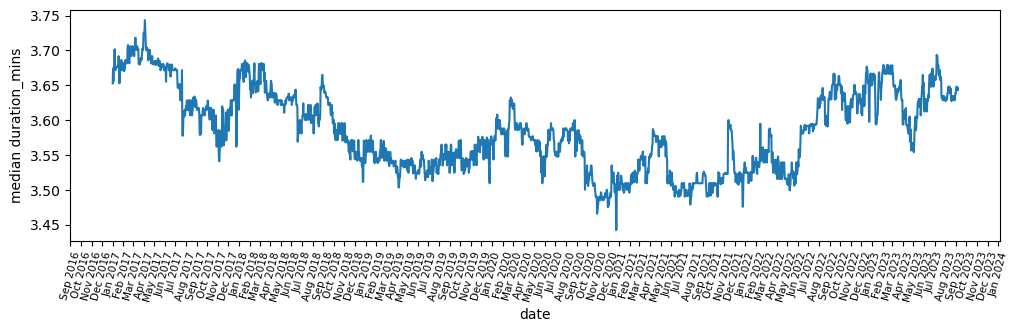

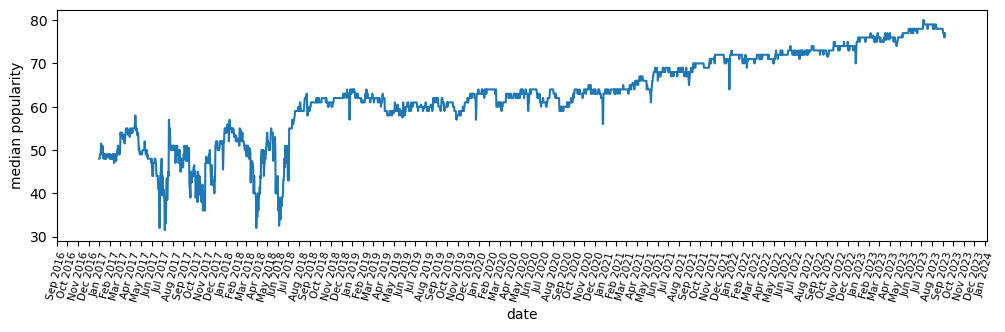

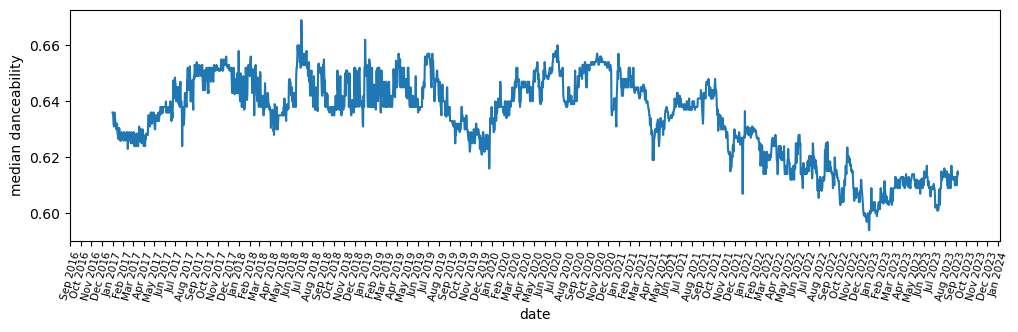

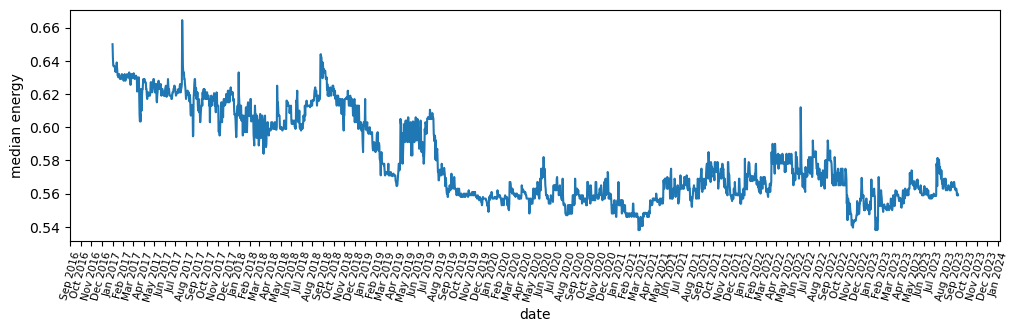

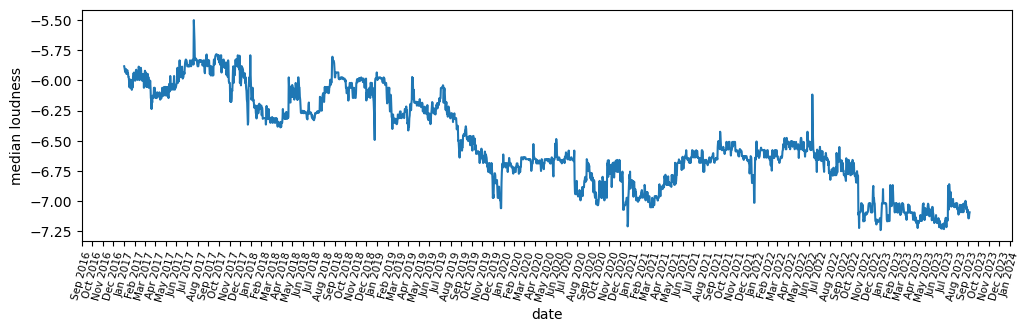

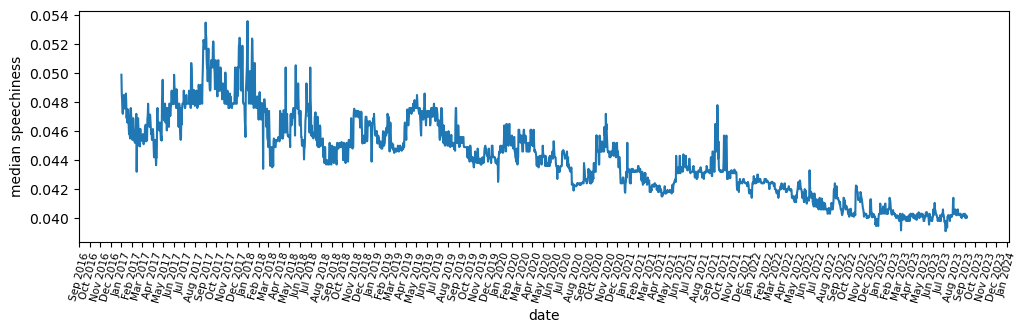

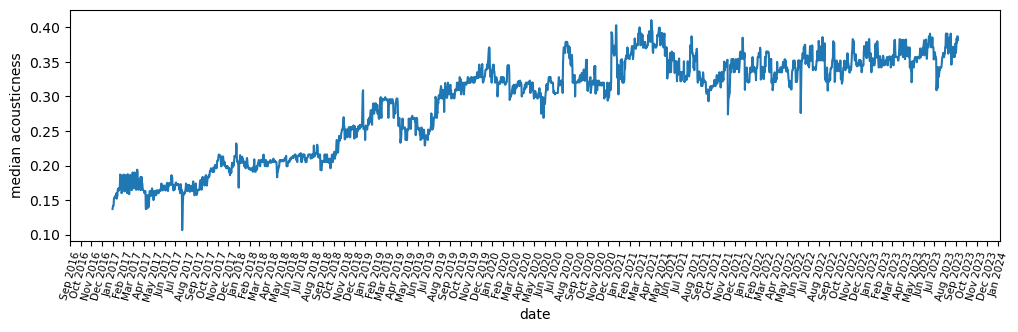

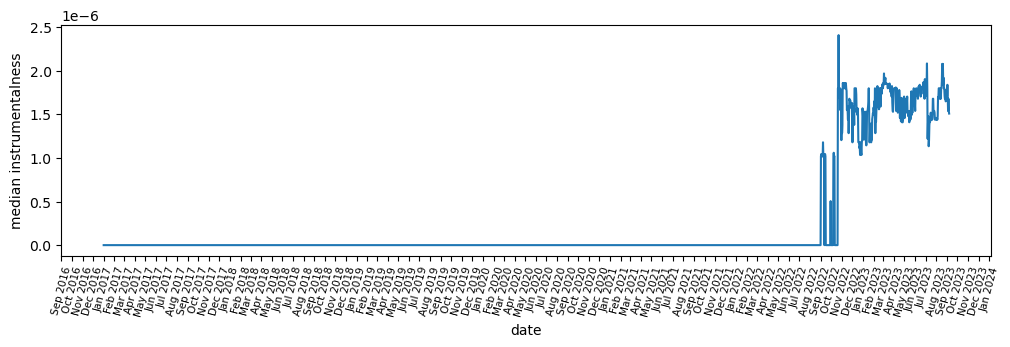

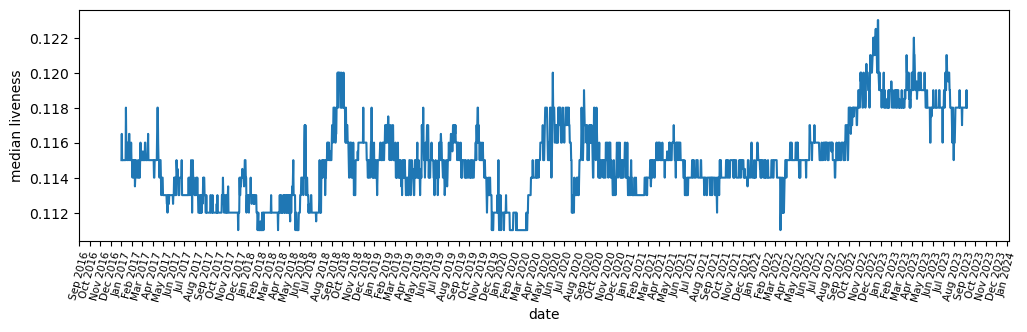

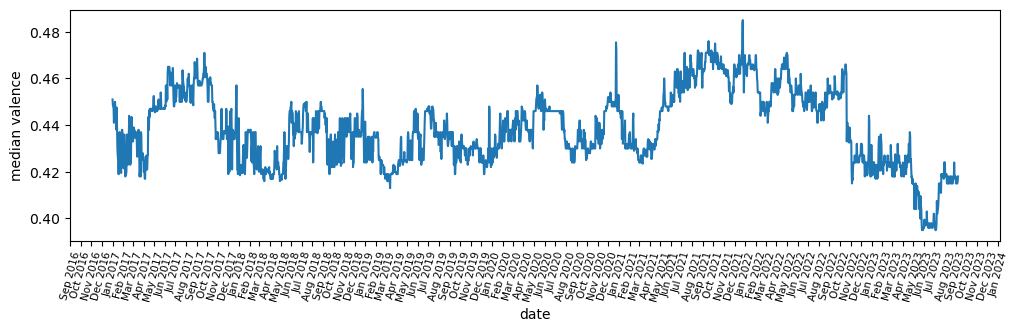

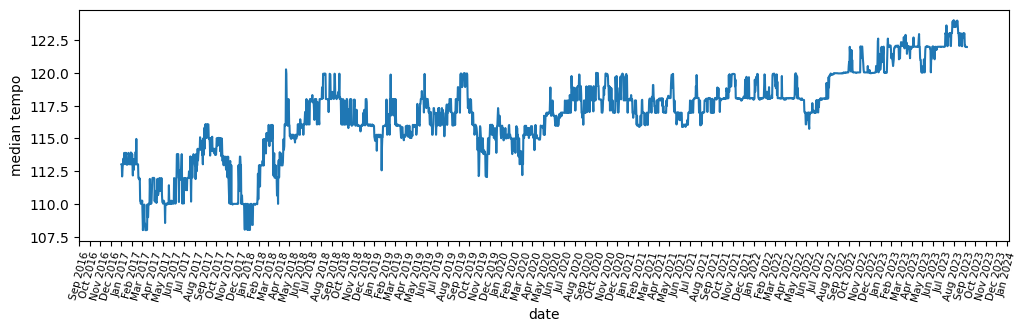

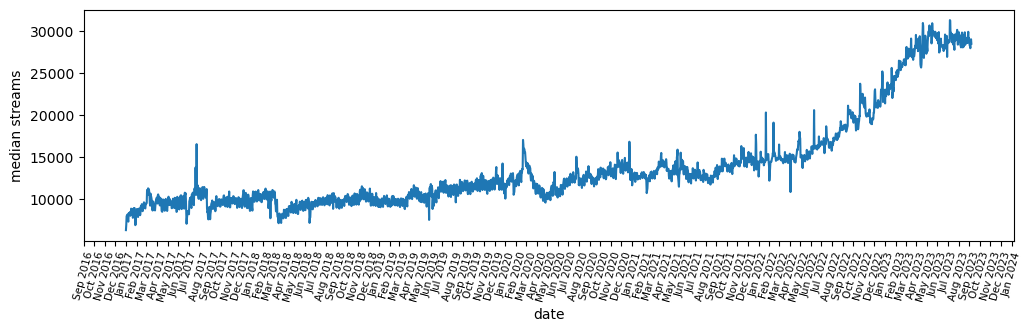

In [83]:
stat_metric = "median";
period = "D";
for feature in features:
    plot_feature(feature, stat_metric, period, charts_track_data_df)

^create explanation